In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import Counter
import math # For calculating grid size for plotting
import json

# --- MobileNetV2 Specific Imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
# --- ResNet50 Specific Imports ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
# --- ConvNeXt Specific Imports ---
from tensorflow.keras.applications import ConvNeXtBase
from tensorflow.keras.applications.convnext import preprocess_input as convnext_preprocess_input

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, LayerNormalization # Added Augmentation Layers
from tensorflow.keras.models import Model
# Removed ImageDataGenerator import as it's replaced by tf.data
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import TopKCategoricalAccuracy

import pickle # For saving history
import glob # For lockfile cleanup

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print("No GPU detected. Training will be very slow.")

# Check TensorFlow version again just to be sure
print("TensorFlow Version:", tf.__version__)

Num GPUs Available:  2
2 Physical GPUs, 2 Logical GPUs
TensorFlow Version: 2.17.1


In [4]:
DATASET_BASE_PATH = '/kaggle/input/zoo-2000/Wild_Animals/'
TRAIN_DIR = os.path.join(DATASET_BASE_PATH, 'Train')
VAL_DIR = os.path.join(DATASET_BASE_PATH, 'Validation')
TEST_DIR = os.path.join(DATASET_BASE_PATH, 'Test')

# Verify directories exist (optional but good practice)
if not os.path.exists(TRAIN_DIR): print(f"ERROR: Training directory not found at {TRAIN_DIR}")
if not os.path.exists(VAL_DIR): print(f"ERROR: Validation directory not found at {VAL_DIR}")
if not os.path.exists(TEST_DIR): print(f"ERROR: Test directory not found at {TEST_DIR}")

CLASSES = ['BEAR','BISON','CHEETAH','ELEPHANT','FOX','GAZELLE','GIRAFFE','GORILLA',
           'HIPPO','HORSE','HYENA','KOALA','LEOPARD','LION','MEERKAT','PIG',
           'PORCUPINE','RHINO','TIGER','WOLF','ZEBRA']
NUM_CLASSES = len(CLASSES)

In [5]:
# Standard Image Size (choose a common size, e.g., for pre-trained models later)
IMG_WIDTH = 224
IMG_HEIGHT = 224
TARGET_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32 # Standard batch size

In [6]:
# Output Directory Setup
OUTPUT_DIR = '/kaggle/working/module_1_outputs'
VIS_DIR = os.path.join(OUTPUT_DIR, 'visualizations')
SUM_DIR = os.path.join(OUTPUT_DIR, 'data_summaries')

os.makedirs(VIS_DIR, exist_ok=True)
os.makedirs(SUM_DIR, exist_ok=True)

print(f"Dataset base path: {DATASET_BASE_PATH}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Target image size: {TARGET_SIZE}")
print(f"Output directory: {OUTPUT_DIR}")

Dataset base path: /kaggle/input/zoo-2000/Wild_Animals/
Number of classes: 21
Target image size: (224, 224)
Output directory: /kaggle/working/module_1_outputs


# Module 1 - Data Prep and Exploration

In [7]:
# --- Step 1: Load and Organize the Dataset (Initial Load for Exploration) ---
# We use ImageDataGenerator primarily for its flow_from_directory method,
# which automatically infers classes from subdirectory names.
# For initial exploration, we only need minimal preprocessing (like rescaling).

print("\n--- Loading Data for Exploration ---")
# Use a simple generator for exploration - rescale is good practice
# Set shuffle=False to get consistent class counts and sample images easily
explore_datagen = ImageDataGenerator(rescale=1./255.)

train_generator_explore = explore_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    classes=CLASSES,          # Ensure order matches your list
    shuffle=False             # Important for consistent exploration
)

validation_generator_explore = explore_datagen.flow_from_directory(
    VAL_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

test_generator_explore = explore_datagen.flow_from_directory(
    TEST_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    shuffle=False
)

# Verify class indices match expectations
print("\nClass Indices mapping:", train_generator_explore.class_indices)
# Create an inverse mapping for easy lookup
index_to_class = {v: k for k, v in train_generator_explore.class_indices.items()}


--- Loading Data for Exploration ---
Found 24430 images belonging to 21 classes.
Found 4170 images belonging to 21 classes.
Found 12137 images belonging to 21 classes.

Class Indices mapping: {'BEAR': 0, 'BISON': 1, 'CHEETAH': 2, 'ELEPHANT': 3, 'FOX': 4, 'GAZELLE': 5, 'GIRAFFE': 6, 'GORILLA': 7, 'HIPPO': 8, 'HORSE': 9, 'HYENA': 10, 'KOALA': 11, 'LEOPARD': 12, 'LION': 13, 'MEERKAT': 14, 'PIG': 15, 'PORCUPINE': 16, 'RHINO': 17, 'TIGER': 18, 'WOLF': 19, 'ZEBRA': 20}



--- Visualizing Sample Images ---
Sample images visualization saved to: /kaggle/working/module_1_outputs/visualizations/sample_images_per_class.png


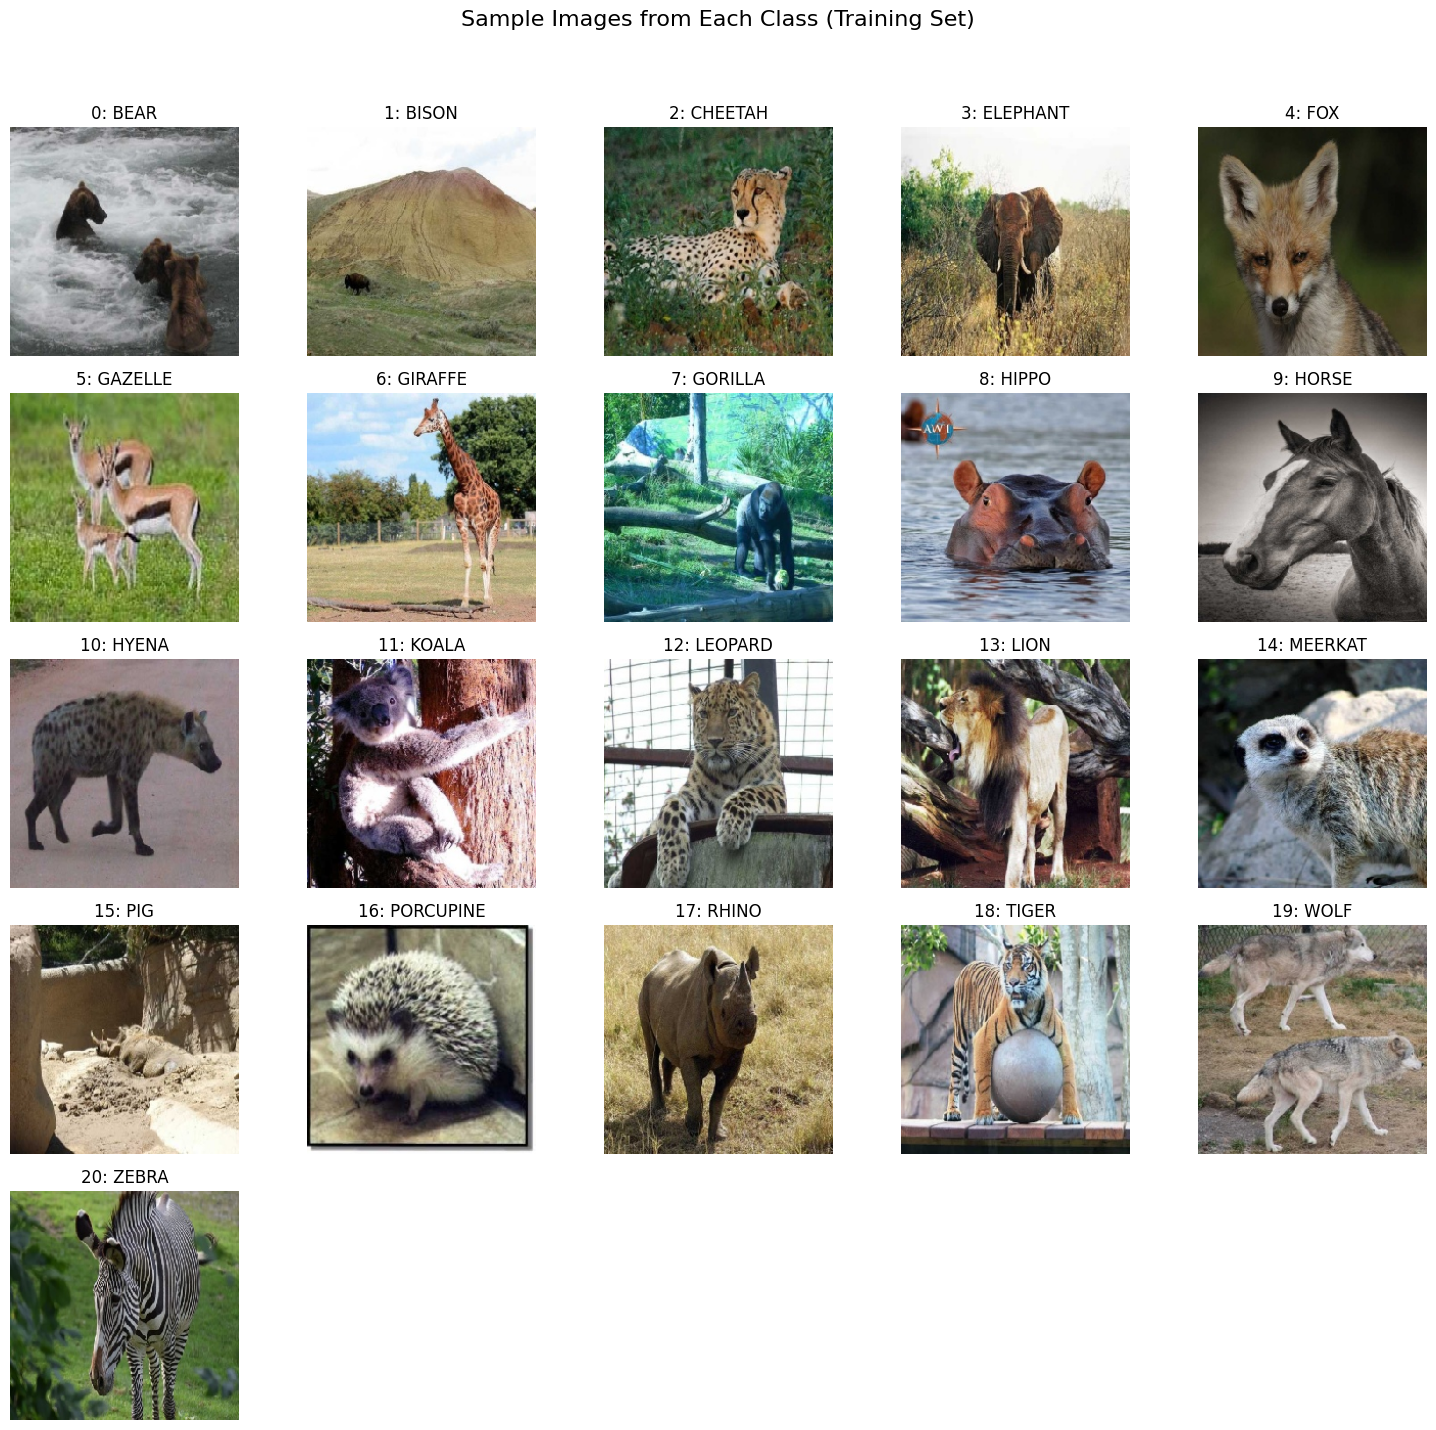

In [8]:
# --- Step 2: Explore the Data - Visualize Sample Images ---
print("\n--- Visualizing Sample Images ---")

# Get a mapping of class index to a list of file paths for that class
class_files = {i: [] for i in range(NUM_CLASSES)}
for i, filename in enumerate(train_generator_explore.filenames):
    class_index = train_generator_explore.classes[i]
    class_files[class_index].append(os.path.join(TRAIN_DIR, filename))

# Calculate grid size
grid_size = math.ceil(math.sqrt(NUM_CLASSES))

plt.figure(figsize=(15, 15))
for i in range(NUM_CLASSES):
    class_name = index_to_class[i]
    plt.subplot(grid_size, grid_size, i + 1)
    if class_files[i]: # Check if the class has images in the training set
        # Load and display the first image found for this class
        img_path = class_files[i][0]
        try:
            img = keras.preprocessing.image.load_img(img_path, target_size=TARGET_SIZE)
            plt.imshow(img)
            plt.title(f"{i}: {class_name}")
            plt.axis('off')
        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
            plt.title(f"{i}: {class_name} (Error)")
            plt.axis('off')
    else:
        plt.title(f"{i}: {class_name} (No images)")
        plt.axis('off')


plt.suptitle("Sample Images from Each Class (Training Set)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
vis_save_path = os.path.join(VIS_DIR, 'sample_images_per_class.png')
plt.savefig(vis_save_path)
print(f"Sample images visualization saved to: {vis_save_path}")
plt.show()


--- Analyzing Class Distribution ---
Training Set - Total Samples: 24430


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Distribution plot saved to: /kaggle/working/module_1_outputs/visualizations/train_class_distribution.png


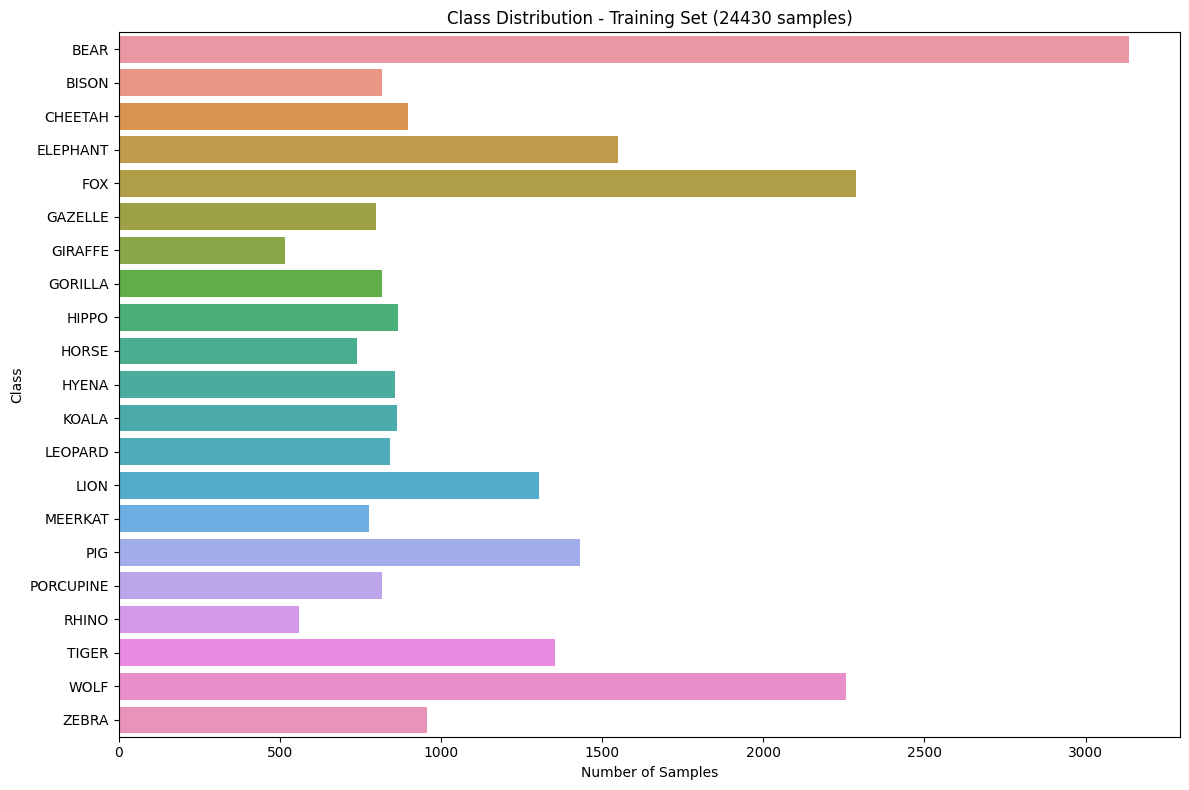

Validation Set - Total Samples: 4170


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Distribution plot saved to: /kaggle/working/module_1_outputs/visualizations/validation_class_distribution.png


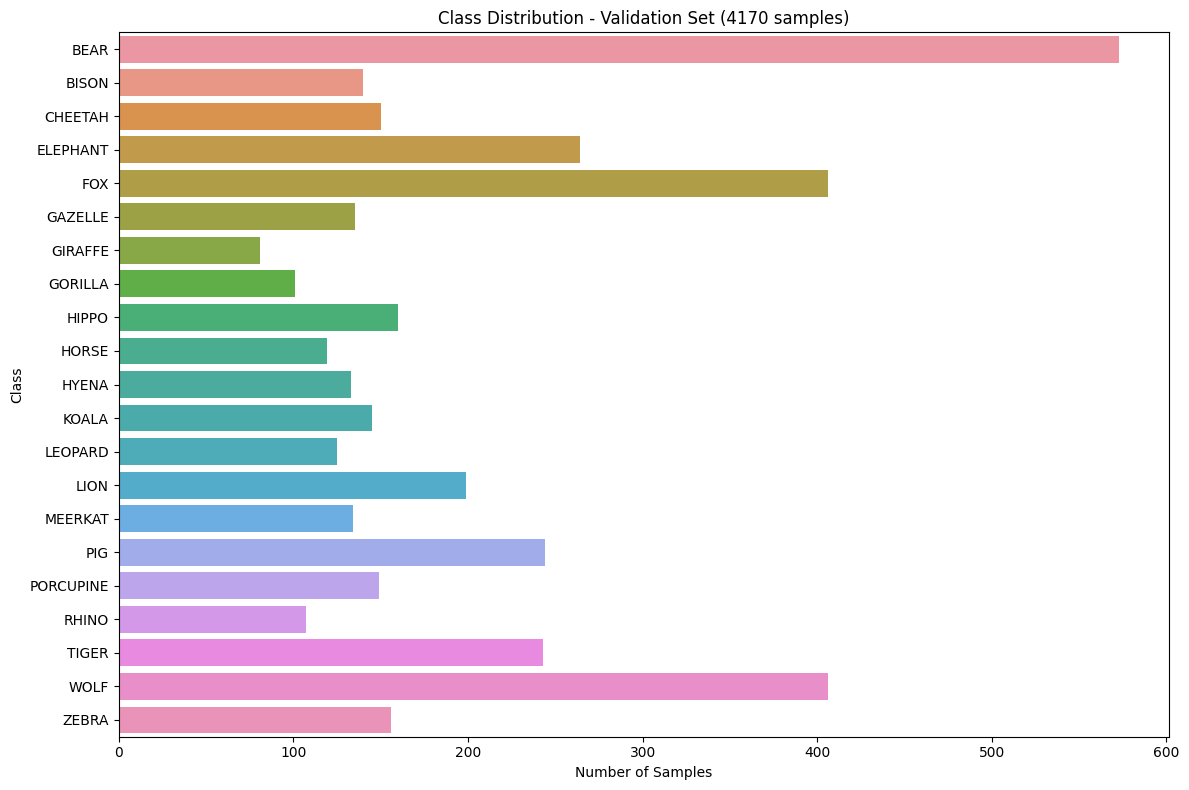

Test Set - Total Samples: 12137


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


Distribution plot saved to: /kaggle/working/module_1_outputs/visualizations/test_class_distribution.png


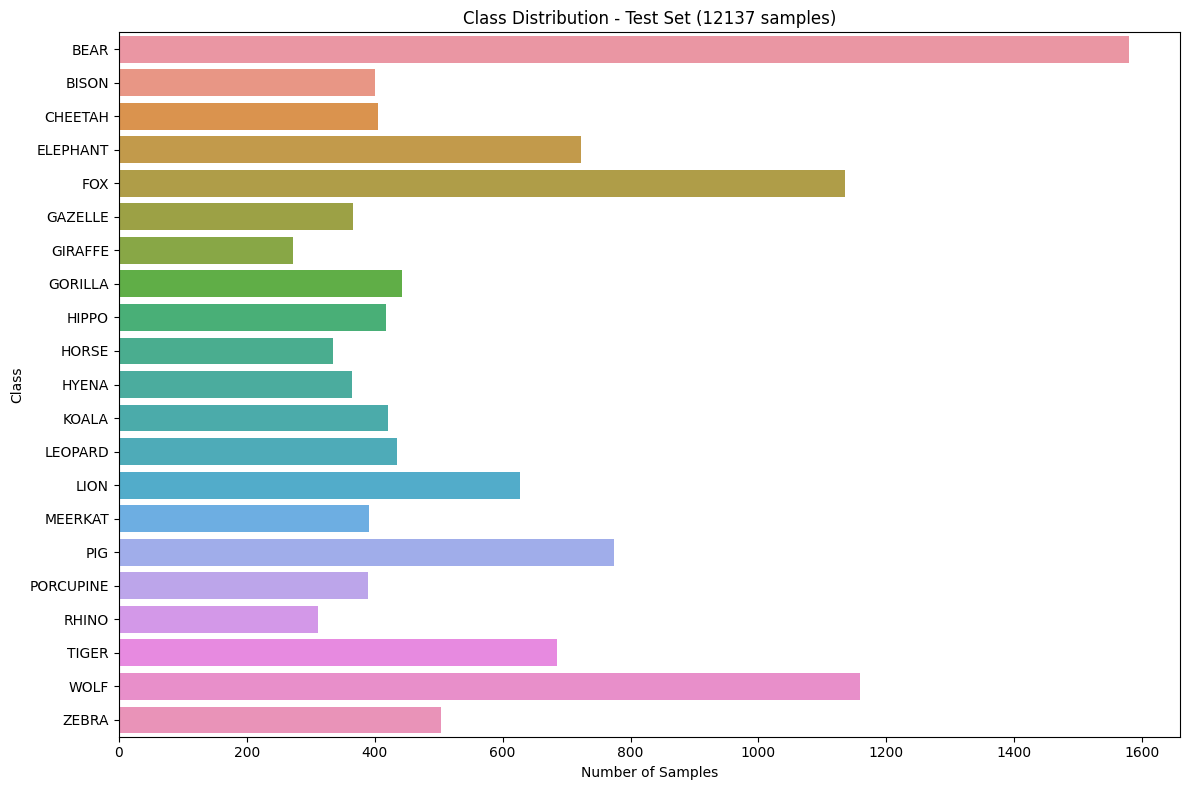

In [9]:
# --- Step 3: Explore the Data - Analyze Class Distribution ---
print("\n--- Analyzing Class Distribution ---")

def plot_class_distribution(generator, title, save_path):
    class_indices = generator.classes
    class_counts = Counter(class_indices)
    sorted_counts = sorted(class_counts.items()) # Sort by class index

    labels = [index_to_class[i] for i, count in sorted_counts]
    counts = [count for i, count in sorted_counts]

    total_samples = sum(counts)
    print(f"{title} - Total Samples: {total_samples}")
    #for label, count in zip(labels, counts):
    #    print(f"  {label}: {count}") # Optional: print counts

    plt.figure(figsize=(12, 8))
    sns.barplot(x=counts, y=labels)
    plt.title(f'Class Distribution - {title} ({total_samples} samples)')
    plt.xlabel('Number of Samples')
    plt.ylabel('Class')
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Distribution plot saved to: {save_path}")
    plt.show()

# Analyze Training Set
train_dist_path = os.path.join(VIS_DIR, 'train_class_distribution.png')
plot_class_distribution(train_generator_explore, "Training Set", train_dist_path)

# Analyze Validation Set
val_dist_path = os.path.join(VIS_DIR, 'validation_class_distribution.png')
plot_class_distribution(validation_generator_explore, "Validation Set", val_dist_path)

# Analyze Test Set
test_dist_path = os.path.join(VIS_DIR, 'test_class_distribution.png')
plot_class_distribution(test_generator_explore, "Test Set", test_dist_path)

# Comment on imbalance: After running the code, observe the bar plots.
# Note if some classes have significantly fewer samples than others in any split.
# This imbalance might require techniques like class weighting or over/undersampling later.

In [10]:
print("\n--- Calculating Class Weights (for potential use later) ---")

# Use the counts calculated earlier for the training set
train_class_indices = train_generator_explore.classes
train_class_counts = Counter(train_class_indices)

# Calculate total samples
total_samples_train = len(train_class_indices)

# Calculate weights: Option 1 - Simple Inverse Frequency
# weight = total_samples / (num_classes * count)
class_weights = {}
num_classes_found = len(train_class_counts) # Use number of classes actually found

for class_index, count in train_class_counts.items():
    # The formula ensures that classes with lower counts get higher weights.
    # Adding a small epsilon or using max(1, count) can prevent division by zero if a class had 0 samples (shouldn't happen with flow_from_directory finding folders)
    weight = total_samples_train / (num_classes_found * count)
    class_weights[class_index] = weight
    class_name = index_to_class[class_index]
    print(f"Class: {class_name} (Index {class_index}), Count: {count}, Weight: {weight:.4f}")


--- Calculating Class Weights (for potential use later) ---
Class: BEAR (Index 0), Count: 3136, Weight: 0.3710
Class: BISON (Index 1), Count: 816, Weight: 1.4257
Class: CHEETAH (Index 2), Count: 898, Weight: 1.2955
Class: ELEPHANT (Index 3), Count: 1550, Weight: 0.7505
Class: FOX (Index 4), Count: 2289, Weight: 0.5082
Class: GAZELLE (Index 5), Count: 798, Weight: 1.4578
Class: GIRAFFE (Index 6), Count: 515, Weight: 2.2589
Class: GORILLA (Index 7), Count: 816, Weight: 1.4257
Class: HIPPO (Index 8), Count: 865, Weight: 1.3449
Class: HORSE (Index 9), Count: 739, Weight: 1.5742
Class: HYENA (Index 10), Count: 856, Weight: 1.3590
Class: KOALA (Index 11), Count: 864, Weight: 1.3465
Class: LEOPARD (Index 12), Count: 841, Weight: 1.3833
Class: LION (Index 13), Count: 1303, Weight: 0.8928
Class: MEERKAT (Index 14), Count: 775, Weight: 1.5011
Class: PIG (Index 15), Count: 1430, Weight: 0.8135
Class: PORCUPINE (Index 16), Count: 817, Weight: 1.4239
Class: RHINO (Index 17), Count: 558, Weight: 2.

In [11]:
# (Place this after the class distribution plotting in Step 3)
# Make sure you have imported numpy as np and the sklearn function

print("\n--- Calculating Class Weights using Scikit-learn ('balanced' method) ---")

# Import necessary function and library
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get the class indices for all training samples
train_labels = train_generator_explore.classes

# Get the unique class indices that are actually present in the training data
# Sorting is important to ensure consistent order if you were to use the weights array directly
unique_classes = np.unique(train_labels)
print(f"Unique class indices found in training data: {unique_classes}")

# Calculate weights using the 'balanced' strategy
# This strategy automatically weights classes inversely proportional to their frequency:
# weight = n_samples / (n_classes * np.bincount(y))
sklearn_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,  # The unique classes present in the data
    y=train_labels           # The labels for each sample
)

# The function returns an array of weights ordered according to `unique_classes`.
# We need to create a dictionary mapping class index -> weight for Keras model.fit
# The zip function pairs the unique class indices with their calculated weights.
class_weights_sklearn = dict(zip(unique_classes, sklearn_weights))

print("\nCalculated Class Weights (Index: Weight):")
# Also print the class name for better readability
for class_index in sorted(class_weights_sklearn.keys()):
    class_name = index_to_class.get(class_index, f"Unknown Index {class_index}") # Use .get for safety
    count = train_class_counts.get(class_index, 0) # Get count from previous Counter
    print(f"  Class: {class_name} (Index {class_index}), Count: {count}, Sklearn Weight: {class_weights_sklearn[class_index]:.4f}")

# Store these weights for potential use in model.fit later
# You will pass this dictionary to the `class_weight` argument of model.fit
# e.g., model.fit(..., class_weight=class_weights_sklearn)

print("\nScikit-learn class weights calculated and stored in 'class_weights_sklearn' dictionary.")
print("Ready for optional use during model training in the next module.")


--- Calculating Class Weights using Scikit-learn ('balanced' method) ---
Unique class indices found in training data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Calculated Class Weights (Index: Weight):
  Class: BEAR (Index 0), Count: 3136, Sklearn Weight: 0.3710
  Class: BISON (Index 1), Count: 816, Sklearn Weight: 1.4257
  Class: CHEETAH (Index 2), Count: 898, Sklearn Weight: 1.2955
  Class: ELEPHANT (Index 3), Count: 1550, Sklearn Weight: 0.7505
  Class: FOX (Index 4), Count: 2289, Sklearn Weight: 0.5082
  Class: GAZELLE (Index 5), Count: 798, Sklearn Weight: 1.4578
  Class: GIRAFFE (Index 6), Count: 515, Sklearn Weight: 2.2589
  Class: GORILLA (Index 7), Count: 816, Sklearn Weight: 1.4257
  Class: HIPPO (Index 8), Count: 865, Sklearn Weight: 1.3449
  Class: HORSE (Index 9), Count: 739, Sklearn Weight: 1.5742
  Class: HYENA (Index 10), Count: 856, Sklearn Weight: 1.3590
  Class: KOALA (Index 11), Count: 864, Sklearn Weight: 1.3465
  Class: LEOPARD (Index 12),

In [12]:
# --- Save the calculated class weights to a file ---
weights_save_path = os.path.join(SUM_DIR, 'class_weights.json')
print(f"\nAttempting to save class weights to: {weights_save_path}") # Added print for debugging path

if not os.path.exists(weights_save_path):
    try:
        class_weights_str_keys = {str(k): v for k, v in class_weights_sklearn.items()}
        with open(weights_save_path, 'w') as f:
            json.dump(class_weights_str_keys, f, indent=4)
        print("Class weights saved successfully.")
    except Exception as e:
        print(f"Error saving class weights: {e}")
else:
    print(f"File already exists at {weights_save_path}, skipping save.")



Attempting to save class weights to: /kaggle/working/module_1_outputs/data_summaries/class_weights.json
File already exists at /kaggle/working/module_1_outputs/data_summaries/class_weights.json, skipping save.


In [13]:
# --- Step 4: Define Practical Preprocessing Levels ---
print("\n--- Defining Practical Preprocessing Levels ---")
print("Note: These levels focus on input image manipulation before the model.")
print("Feature extraction, pattern recognition, and classification happen INSIDE the model.")

# Level 1: Baseline Preprocessing (For Validation & Test Sets, and as base for Training)
# Minimal necessary steps: resizing (via target_size) and normalization.
baseline_preprocess_datagen = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values to [0, 1]
    # target_size is specified in flow_from_directory
)
print("\nDefined 'Baseline' Preprocessing (for Val/Test): Rescale")
print("   - Applied via ImageDataGenerator's rescale parameter.")
print("   - Resizing is handled by 'target_size' in flow_from_directory.")


# Level 2: Augmented Preprocessing (For Training Set ONLY)
# Adds augmentations ON TOP of baseline preprocessing.
augmented_preprocess_datagen = ImageDataGenerator(
    rescale=1./255,         # Normalize (Baseline)
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.1,  # Randomly shift horizontally
    height_shift_range=0.1, # Randomly shift vertically
    shear_range=0.1,        # Apply shear transformations
    zoom_range=0.1,         # Randomly zoom
    horizontal_flip=True,   # Randomly flip horizontally
    fill_mode='nearest'     # How to fill newly created pixels
)
print("\nDefined 'Augmented' Preprocessing (for Training): Baseline + Augmentations")
print("   - Includes Rescale.")
print("   - Adds Rotation, Shift, Shear, Zoom, Flip.")


# --- How the Model Handles CV Levels Internally (Explanation) ---
print("\n--- How the Model Achieves CV Levels Internally ---")
print("Instead of pre-applying complex steps, the CNN learns them:")
print("1. Low-Level (Features): Early Convolutional layers automatically learn to detect edges, textures, gradients, and simple shapes directly from pixels.")
print("2. Mid-Level (Patterns/Classification): Deeper Convolutional layers combine these simple features into more complex patterns and object parts. The final Dense (fully connected) layers use these high-level features to classify the image.")
print("3. High-Level (Understanding): The overall architecture and the classification output represent the model's 'understanding' for this specific task. More complex tasks might require different architectures.")

# Reminder on Usage:
# train_generator = augmented_preprocess_datagen.flow_from_directory(TRAIN_DIR, target_size=TARGET_SIZE, ...)
# validation_generator = baseline_preprocess_datagen.flow_from_directory(VAL_DIR, target_size=TARGET_SIZE, ...)
# test_generator = baseline_preprocess_datagen.flow_from_directory(TEST_DIR, target_size=TARGET_SIZE, ...)

print("\nPreprocessing definitions updated and clarified.")


--- Defining Practical Preprocessing Levels ---
Note: These levels focus on input image manipulation before the model.
Feature extraction, pattern recognition, and classification happen INSIDE the model.

Defined 'Baseline' Preprocessing (for Val/Test): Rescale
   - Applied via ImageDataGenerator's rescale parameter.
   - Resizing is handled by 'target_size' in flow_from_directory.

Defined 'Augmented' Preprocessing (for Training): Baseline + Augmentations
   - Includes Rescale.
   - Adds Rotation, Shift, Shear, Zoom, Flip.

--- How the Model Achieves CV Levels Internally ---
Instead of pre-applying complex steps, the CNN learns them:
1. Low-Level (Features): Early Convolutional layers automatically learn to detect edges, textures, gradients, and simple shapes directly from pixels.
2. Mid-Level (Patterns/Classification): Deeper Convolutional layers combine these simple features into more complex patterns and object parts. The final Dense (fully connected) layers use these high-level f

In [14]:
# --- Step 5: Summary ---
print("\n--- Module 1 Summary ---")
print(f"Primary Tools: TensorFlow/Keras, Matplotlib, Seaborn, NumPy, OS, Scikit-learn (for class weights)")
print(f"Working Environment: Kaggle Notebooks")
print(f"Dataset loaded and explored from: {DATASET_BASE_PATH}")
print(f"Outputs saved in: {OUTPUT_DIR}")
print(f"  - Visualizations (Samples, Distributions) in: {VIS_DIR}")
print(f"  - Data Summaries (Class Weights calculated) in: {SUM_DIR}") # Can mention class weights were calculated
print("\nClass Imbalance:")
print(f"  - Identified significant imbalance (e.g., BEAR, FOX, WOLF over-represented).")
print(f"  - Calculated class weights using sklearn 'balanced' method (stored in 'class_weights_sklearn') for potential use in model training.")

print("\nPractical Preprocessing Strategies Defined:")
print("  - Baseline Preprocessing: Resizing (via target_size) and Rescaling (0-1 Normalization).")
print("      -> Intended for Validation and Test sets.")
print("  - Augmented Preprocessing: Baseline + Augmentations (Rotation, Shift, Shear, Zoom, Flip).")
print("      -> Intended for the Training set ONLY to improve robustness.")

print("\nKey Understanding:")
print("  - Basic image manipulation (resizing, normalization, augmentation) is done BEFORE the model.")
print("  - Complex CV tasks (feature extraction, pattern recognition, classification) are learned INTERNALLY by the CNN layers.")

print("\nModule 1 Complete. Dataset understood, pre-processing defined, potential imbalance addressed (weights calculated).")
print("Ready to proceed to Module 2: Model Building.")


--- Module 1 Summary ---
Primary Tools: TensorFlow/Keras, Matplotlib, Seaborn, NumPy, OS, Scikit-learn (for class weights)
Working Environment: Kaggle Notebooks
Dataset loaded and explored from: /kaggle/input/zoo-2000/Wild_Animals/
Outputs saved in: /kaggle/working/module_1_outputs
  - Visualizations (Samples, Distributions) in: /kaggle/working/module_1_outputs/visualizations
  - Data Summaries (Class Weights calculated) in: /kaggle/working/module_1_outputs/data_summaries

Class Imbalance:
  - Identified significant imbalance (e.g., BEAR, FOX, WOLF over-represented).
  - Calculated class weights using sklearn 'balanced' method (stored in 'class_weights_sklearn') for potential use in model training.

Practical Preprocessing Strategies Defined:
  - Baseline Preprocessing: Resizing (via target_size) and Rescaling (0-1 Normalization).
      -> Intended for Validation and Test sets.
  - Augmented Preprocessing: Baseline + Augmentations (Rotation, Shift, Shear, Zoom, Flip).
      -> Intende

# Module 2: Model Building

### MobileNet v2

In [6]:
print("--- Ensuring Module 1 Variables are Accessible ---")
# Add checks or print statements if needed to confirm Module 1 vars exist
print(f"Train Directory: {TRAIN_DIR}")
print(f"Validation Directory: {VAL_DIR}")
print(f"Number of Classes: {NUM_CLASSES}")

# --- Module 2 Configuration ---
MODULE_2_OUTPUT_DIR = '/kaggle/working/module_2_outputs'
os.makedirs(MODULE_2_OUTPUT_DIR, exist_ok=True)

# File Paths
WEIGHTS_FILE = os.path.join(SUM_DIR, 'class_weights.json') # Path from Module 1
MODEL_SAVE_PATH_M2 = os.path.join(MODULE_2_OUTPUT_DIR, 'mobilenetv2_tfdata_best.keras') # Updated name for clarity
HISTORY_SAVE_PATH_M2 = os.path.join(MODULE_2_OUTPUT_DIR, 'mobilenetv2_tfdata_history.pkl') # Updated name

# Training Parameters
EPOCHS = 30 # Adjust as needed
LEARNING_RATE = 0.0001 # Lower learning rate for fine-tuning
PATIENCE = 5 # For EarlyStopping
AUTOTUNE = tf.data.AUTOTUNE # For tf.data parallel calls

print(f"--- Module 2 Setup ---")
print(f"Output directory: {MODULE_2_OUTPUT_DIR}")
print(f"Model save path: {MODEL_SAVE_PATH_M2}")
print(f"History save path: {HISTORY_SAVE_PATH_M2}")
print(f"Class weights file: {WEIGHTS_FILE}")

--- Ensuring Module 1 Variables are Accessible ---
Train Directory: /kaggle/input/zoo-2000/Wild_Animals/Train
Validation Directory: /kaggle/input/zoo-2000/Wild_Animals/Validation
Number of Classes: 21
--- Module 2 Setup ---
Output directory: /kaggle/working/module_2_outputs
Model save path: /kaggle/working/module_2_outputs/mobilenetv2_tfdata_best.keras
History save path: /kaggle/working/module_2_outputs/mobilenetv2_tfdata_history.pkl
Class weights file: /kaggle/working/module_1_outputs/data_summaries/class_weights.json


In [8]:
# --- Build and Compile Model---
print("\n--- Building Model---")

# 2. Load Pre-trained MobileNetV2 Base (Inside Scope)
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
print("Base MobileNetV2 model loaded.")

# 3. Freeze Base Layers (Inside Scope)
base_model.trainable = False
print("Base model layers frozen.")

# 4. Add Custom Classification Head (Inside Scope)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
print("Custom head added.")

# 7. Model Compilation (Inside Scope)
print("\n--- Compiling the Model within Strategy Scope ---")
# Consider scaling learning rate with global batch size if needed later:
# scaled_lr = LEARNING_RATE * NUM_GPUS
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Start with original LR
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)
print("Model compiled successfully within strategy scope.")

# Model summary can be called outside the scope
print("\n--- Final Model Summary (Multi-GPU) ---")
model.summary()


--- Building Model---
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Base MobileNetV2 model loaded.
Base model layers frozen.
Custom head added.

--- Compiling the Model within Strategy Scope ---
Model compiled successfully within strategy scope.

--- Final Model Summary (Multi-GPU) ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,591,317 (9.89 MB)

 Trainable params: 333,333 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
print("\n--- Creating tf.data Pipelines ---")

# --- Define Cache File Paths ---
# Ensure these paths are within a writable directory like /kaggle/working/
TRAIN_CACHE_FILE = '/kaggle/working/mobilenetv2_tf_train_cache'
VAL_CACHE_FILE = '/kaggle/working/mobilenetv2_tf_val_cache'
print(f"Using disk cache for training data: {TRAIN_CACHE_FILE}")
print(f"Using disk cache for validation data: {VAL_CACHE_FILE}")

# --- Helper Functions ---
def preprocess_mobilenet(image, label):
    # Ensure image is float32 before preprocessing
    image = tf.cast(image, tf.float32)
    # Applies MobileNetV2 specific preprocessing
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

# Define augmentation layers (applied only during training)
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.05), # Corresponds roughly to 20 degrees if input is [-1,1] range, adjust if needed
  RandomZoom(0.05),
  # Add tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1) for shifts if desired
], name="data_augmentation")

def augment_data(image, label):
    # Apply the sequential augmentation model
    # Ensure image is float32 for augmentation layers
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image, training=True)
    return image, label


--- Creating tf.data Pipelines ---
Using disk cache for training data: /kaggle/working/mobilenetv2_tf_train_cache
Using disk cache for validation data: /kaggle/working/mobilenetv2_tf_val_cache


In [10]:
# --- Create Training Dataset ---
print("Creating Training Dataset...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels='inferred',
    label_mode='categorical', # Ensure this matches loss function expectation
    class_names=CLASSES,      # Explicitly set class names to match Module 1 order
    image_size=TARGET_SIZE,
    interpolation='nearest',
    batch_size=None,          # Process images individually first
    shuffle=True,
    seed=123
)

# Verify class names match (important sanity check)
if train_ds.class_names != CLASSES:
    print("FATAL ERROR: Class name order mismatch between tf.data and Module 1!")
    print("Module 1 Order:", CLASSES)
    print("tf.data Order:", train_ds.class_names)
    # Stop execution or handle error appropriately
    raise ValueError("Class order mismatch detected!")
else:
    print("Class name order verified.")

# Cache after loading/resizing (requires sufficient RAM or disk space)
# Note: First epoch will be slower as it populates the cache.
print("Applying Caching to Training Data (may take time on first epoch)...")
train_ds = train_ds.cache(filename=TRAIN_CACHE_FILE) # Cache to disk.

# Apply augmentations *after* caching
print("Mapping Augmentations...")
train_ds = train_ds.map(augment_data, num_parallel_calls=AUTOTUNE)

# Apply MobileNetV2 preprocessing *after* augmentation
print("Mapping MobileNetV2 Preprocessing...")
train_ds = train_ds.map(preprocess_mobilenet, num_parallel_calls=AUTOTUNE)

# Batch the data
print("Batching Training Data...")
train_ds = train_ds.batch(BATCH_SIZE)

# Prefetch for performance
print("Applying Prefetching...")
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
print("Training Dataset Pipeline Ready.")

Creating Training Dataset...
Found 24430 files belonging to 21 classes.
Class name order verified.
Applying Caching to Training Data (may take time on first epoch)...
Mapping Augmentations...
Mapping MobileNetV2 Preprocessing...
Batching Training Data...
Applying Prefetching...
Training Dataset Pipeline Ready.


In [11]:
# --- Create Validation Dataset ---
print("Creating Validation Dataset...")
val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASSES,
    image_size=TARGET_SIZE,
    interpolation='nearest',
    batch_size=None,
    shuffle=False
)

# Apply disk caching *after* loading/resizing
print(f"Applying Disk Caching to Validation Data (Writing to {VAL_CACHE_FILE})...")
val_ds = val_ds.cache(filename=VAL_CACHE_FILE)

# Apply MobileNetV2 preprocessing (NO augmentation)
print("Mapping MobileNetV2 Preprocessing...")
val_ds = val_ds.map(preprocess_mobilenet, num_parallel_calls=AUTOTUNE)

# Batch the data
print("Batching Validation Data...")
val_ds = val_ds.batch(BATCH_SIZE)

# Prefetch for performance
print("Applying Prefetching...")
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
print("Validation Dataset Pipeline Ready.")

Creating Validation Dataset...
Found 4170 files belonging to 21 classes.
Applying Disk Caching to Validation Data (Writing to /kaggle/working/mobilenetv2_tf_val_cache)...
Mapping MobileNetV2 Preprocessing...
Batching Validation Data...
Applying Prefetching...
Validation Dataset Pipeline Ready.


In [12]:
print("\n--- Loading Class Weights from File ---")
class_weights = None
try:
    with open(WEIGHTS_FILE, 'r') as f:
        class_weights_str_keys = json.load(f)
        # Convert string keys back to integers for model.fit
        class_weights = {int(k): float(v) for k, v in class_weights_str_keys.items()}
    print(f"Successfully loaded class weights from {WEIGHTS_FILE}")
    # Optional: Verify consistency
    if len(class_weights) != NUM_CLASSES:
         print(f"WARNING: Loaded class weights ({len(class_weights)}) != NUM_CLASSES ({NUM_CLASSES}). Check {WEIGHTS_FILE}")
         # class_weights = None # Decide if you want to disable weights on mismatch
except FileNotFoundError:
    print(f"WARNING: Class weights file not found at {WEIGHTS_FILE}. Training without class weights.")
except Exception as e:
    print(f"ERROR loading class weights: {e}. Proceeding without weights.")


--- Loading Class Weights from File ---
Successfully loaded class weights from /kaggle/working/module_1_outputs/data_summaries/class_weights.json


In [13]:
print("\n--- Compiling the Model ---")
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)
print("Model compiled successfully.")


--- Compiling the Model ---
Model compiled successfully.


In [14]:
print("\n--- Defining Callbacks ---")
early_stopping = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True, verbose=1, mode='max')
model_checkpoint = ModelCheckpoint(filepath=MODEL_SAVE_PATH_M2, monitor='val_accuracy', save_best_only=True, save_weights_only=False, mode='max', verbose=1)
callbacks_list = [early_stopping, model_checkpoint]
print("EarlyStopping and ModelCheckpoint defined.")


--- Defining Callbacks ---
EarlyStopping and ModelCheckpoint defined.


In [ ]:
print("\n--- Starting Model Training with tf.data ---")

history = model.fit(
    train_ds,                      # Pass the tf.data training dataset
    epochs=EPOCHS,
    validation_data=val_ds,        # Pass the tf.data validation dataset
    callbacks=callbacks_list,
    class_weight=class_weights,    # Pass loaded class weights
    verbose=1
    # No workers or use_multiprocessing needed with tf.data
)
print("--- Model Training Finished ---")

# Save history (no changes needed here)
try:
    with open(HISTORY_SAVE_PATH_M2, 'wb') as f:
        pickle.dump(history.history, f)-------------
    print(f"Training history saved successfully to {HISTORY_SAVE_PATH_M2}")
except Exception as e:
    print(f"Error saving training history: {e}")

In [ ]:
try:
    # Load the entire model
    loaded_model = tf.keras.models.load_model(MODEL_SAVE_PATH_M2)
    print("MNv2 model loaded successfully!")
    loaded_model.summary() # Verify the model structure
except Exception as e:
    print(f"Error loading model from {MODEL_SAVE_PATH_M2}: {e}")
    print("Please ensure the path is correct and the file exists in the input directory.")
    loaded_model = None # Set to None if loading failed


--- Visualizing Layer Outputs for a Single Image Across Depths ---
Original batch shape: (32, 224, 224, 3)
Shape of single image prepared for prediction: (1, 224, 224, 3)


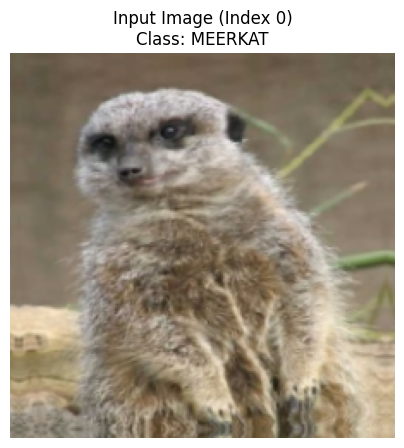


--- Displaying Activations for Image 0 Across Layers ---

--- Layer: Conv_1_bn ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Activations shape for this layer: (7, 7, 1280)


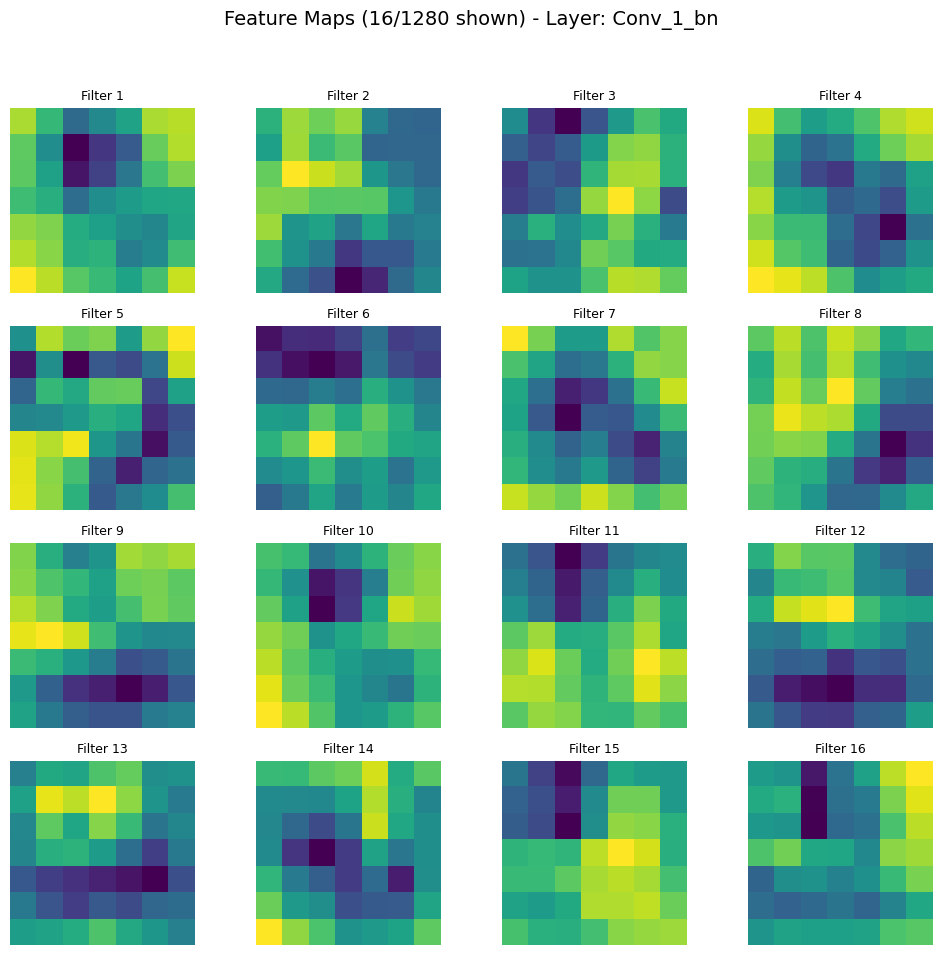

Description for Layer 'Conv_1_bn':
  - Early layer: Learns basic features (edges, textures, gradients). Retains spatial resemblance.

--- Layer: block_3_expand_relu ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
Activations shape for this layer: (56, 56, 144)


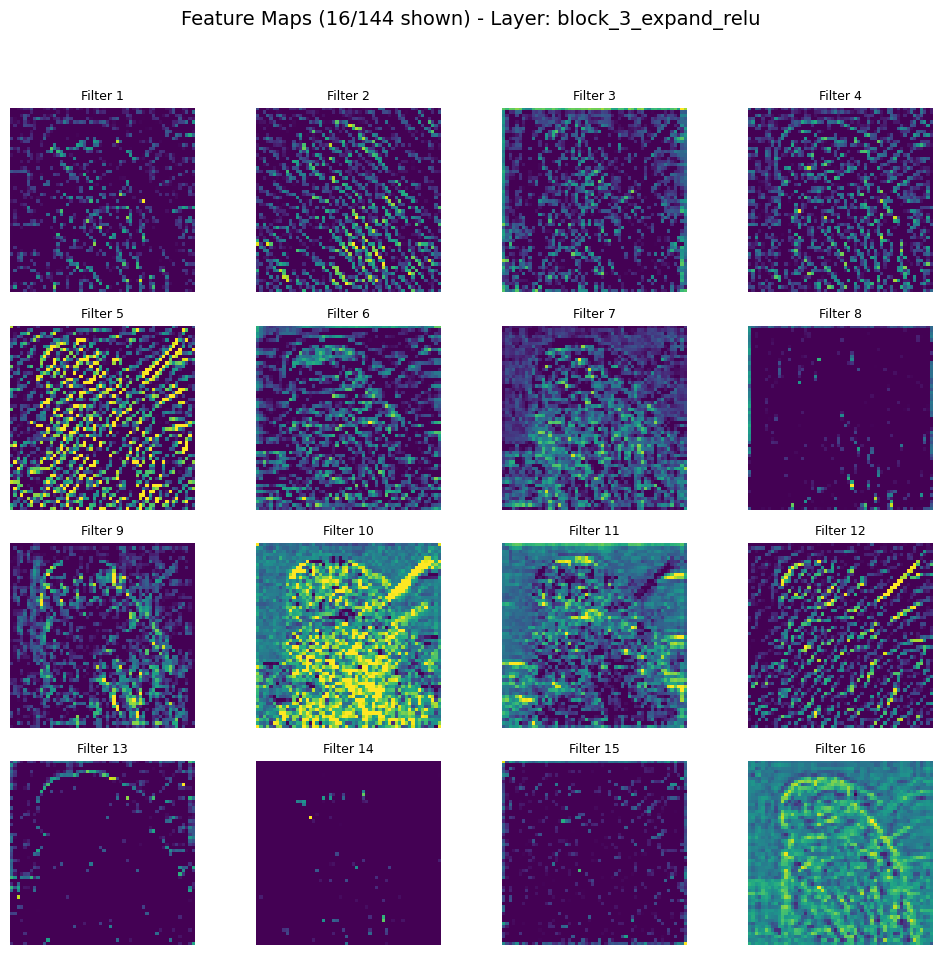

Description for Layer 'block_3_expand_relu':
  - Mid-depth layer (Inverted Residual Block): Learns more complex patterns (object parts, fur). Activations become more abstract.
    (Showing output after Expansion Convolution + ReLU)

--- Layer: block_6_depthwise_relu ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Activations shape for this layer: (14, 14, 192)


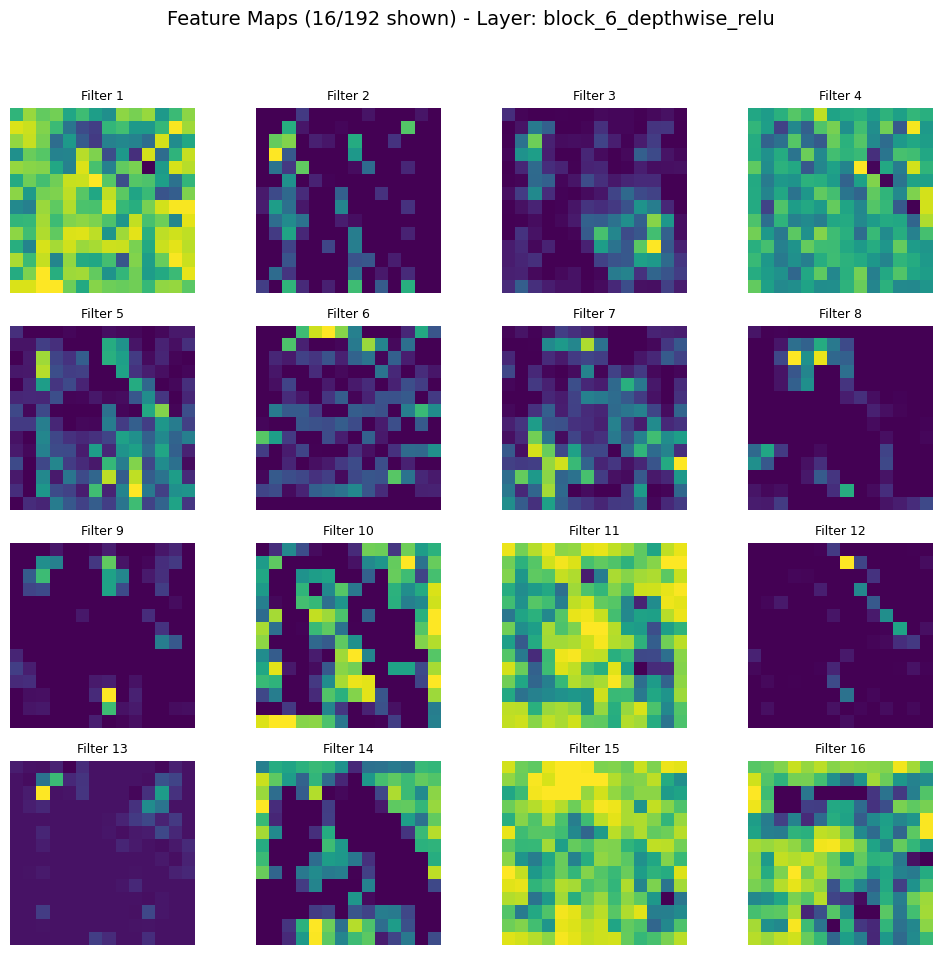

Description for Layer 'block_6_depthwise_relu':
  - Mid-depth layer (Inverted Residual Block): Learns more complex patterns (object parts, fur). Activations become more abstract.
    (Showing output after Depthwise Convolution + ReLU)

--- Layer: block_13_expand_relu ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Activations shape for this layer: (14, 14, 576)


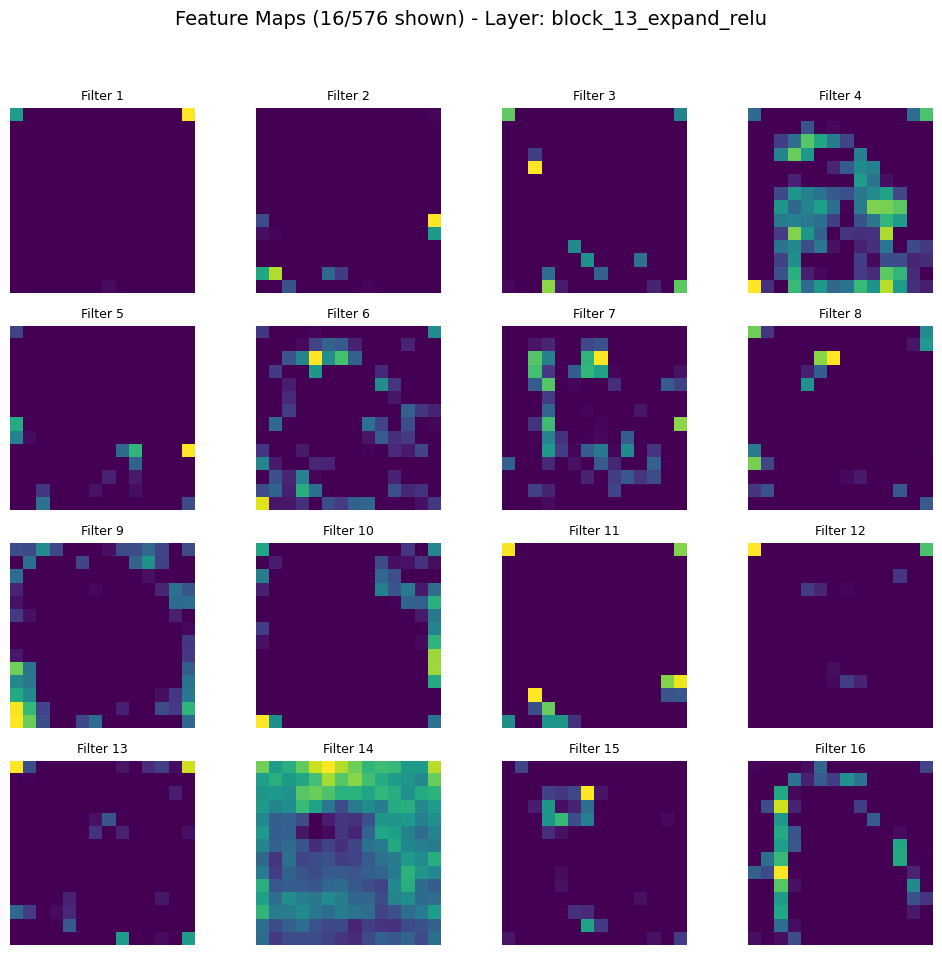

Description for Layer 'block_13_expand_relu':
  - Deeper layer (Inverted Residual Block): Responds to highly complex, class-specific features. Activations very abstract.
    (Showing output after Expansion Convolution + ReLU)


In [15]:
print("\n--- Visualizing Layer Outputs for a Single Image Across Depths ---")

# --- Configuration for Visualization ---
image_index_to_show = 0 # Choose which image from the batch (0 for the first)
layer_names_to_visualize = [
    'Conv_1_bn',           # Early layer (Batch Norm after first Conv)
    'block_3_expand_relu', # Mid-depth layer
    'block_6_depthwise_relu', # Mid-depth layer (after depthwise)
    'block_13_expand_relu' # Deeper layer
]
filters_to_show_per_layer = 16 # Max filters to show for each layer

# --- Get Batch and Select Image ---
try:
    # Ensure the model used here is the trained one
    if 'model' not in locals() or model is None:
         print("Loading the best saved model for visualization...")
         model = tf.keras.models.load_model(MODEL_SAVE_PATH_M2)
         print("Model loaded.")

    # Get a batch of images from the training dataset
    img_batch, label_batch = next(iter(train_ds))
    print(f"Original batch shape: {img_batch.shape}")

    # Select the single image and label to visualize
    single_img_processed = img_batch[image_index_to_show]
    single_label_one_hot = label_batch[image_index_to_show]
    # Add batch dimension back for prediction with intermediate models
    single_img_batch = np.expand_dims(single_img_processed, axis=0)
    print(f"Shape of single image prepared for prediction: {single_img_batch.shape}")

    # --- Display Input Image (Once) ---
    # Reverse preprocessing for display
    display_img = (single_img_processed.numpy() + 1.0) * 0.5
    display_img = np.clip(display_img, 0, 1)
    label_index = np.argmax(single_label_one_hot)
    label_name = CLASSES[label_index]

    plt.figure(figsize=(5, 5))
    plt.imshow(display_img)
    plt.title(f"Input Image (Index {image_index_to_show})\nClass: {label_name}")
    plt.axis('off')
    plt.show()

    # --- Loop Through Layers for Visualization ---
    print(f"\n--- Displaying Activations for Image {image_index_to_show} Across Layers ---")

    for layer_name in layer_names_to_visualize:
        print(f"\n--- Layer: {layer_name} ---")
        try:
            # Create model to output activations from the current layer
            intermediate_layer_model = Model(inputs=model.input,
                                             outputs=model.get_layer(layer_name).output)

            # Get the activations for the single image batch
            activations = intermediate_layer_model.predict(single_img_batch)
            # Remove batch dimension for plotting (shape becomes (h, w, num_filters))
            activation_map = activations[0]
            print(f"Activations shape for this layer: {activation_map.shape}")

            num_filters_in_activation = activation_map.shape[-1]
            current_filters_to_show = min(filters_to_show_per_layer, num_filters_in_activation)

            # --- Display Feature Maps (Activations) ---
            grid_cols = 4 # Or 8 if showing more filters
            grid_rows = current_filters_to_show // grid_cols + (current_filters_to_show % grid_cols > 0)

            plt.figure(figsize=(grid_cols * 2.5, grid_rows * 2.5))
            plt.suptitle(f"Feature Maps ({current_filters_to_show}/{num_filters_in_activation} shown) - Layer: {layer_name}", fontsize=14)

            for filter_index in range(current_filters_to_show):
                plt.subplot(grid_rows, grid_cols, filter_index + 1)
                plt.imshow(activation_map[:, :, filter_index], cmap='viridis')
                plt.title(f"Filter {filter_index+1}", fontsize=9)
                plt.axis('off')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            plt.show()

            # --- Add Description ---
            print(f"Description for Layer '{layer_name}':")
            # (Using the same descriptive logic as before based on layer name)
            if 'Conv_1' in layer_name or 'block_1_' in layer_name or 'block_2_' in layer_name:
                 print("  - Early layer: Learns basic features (edges, textures, gradients). Retains spatial resemblance.")
            elif 'block_3_' in layer_name or 'block_4_' in layer_name or 'block_5_' in layer_name or 'block_6_' in layer_name:
                 print("  - Mid-depth layer (Inverted Residual Block): Learns more complex patterns (object parts, fur). Activations become more abstract.")
                 if '_depthwise_relu' in layer_name: print("    (Showing output after Depthwise Convolution + ReLU)")
                 elif '_expand_relu' in layer_name: print("    (Showing output after Expansion Convolution + ReLU)")
            elif 'block_10_' in layer_name or 'block_11_' in layer_name or 'block_12_' in layer_name or 'block_13_' in layer_name or 'block_14_' in layer_name or 'block_15_' in layer_name:
                 print("  - Deeper layer (Inverted Residual Block): Responds to highly complex, class-specific features. Activations very abstract.")
                 if '_depthwise_relu' in layer_name: print("    (Showing output after Depthwise Convolution + ReLU)")
                 elif '_expand_relu' in layer_name: print("    (Showing output after Expansion Convolution + ReLU)")
            else: # Deeper layers or final layers before GAP
                 print("  - Very deep layer: Features are highly abstract and specialized for classification.")

        except ValueError as e:
             print(f"  ERROR: Could not find layer '{layer_name}'. Check model.summary() for valid names. Skipping this layer.")
             print(f"  ({e})")
        except Exception as e_inner:
             print(f"  An error occurred processing layer {layer_name}: {e_inner}. Skipping this layer.")


except NameError as e:
    print(f"ERROR: A required variable (like 'model' or 'train_ds') might not be defined. Ensure previous cells ran correctly.")
    print(e)
except Exception as e_outer:
    print(f"An overall error occurred during visualization setup: {e_outer}")

In [16]:
print("\n--- Module 2 (MobileNetV2 with tf.data) Summary ---")
print(f"1. Built MobileNetV2 model: Loaded base, froze layers, added custom head.")
print(f"2. Created efficient tf.data pipelines for train/validation sets:")
print(f"   - Used image_dataset_from_directory, caching, parallel mapping, batching, prefetching.")
print(f"   - Applied augmentations (train only) and MobileNetV2 preprocessing via .map().")
print(f"3. Loaded class weights from '{os.path.basename(WEIGHTS_FILE)}'.")
print(f"4. Compiled model (Adam LR={LEARNING_RATE}, categorical_crossentropy, accuracy, top_5_accuracy).")
print(f"5. Trained model using tf.data datasets with EarlyStopping and ModelCheckpoint.")
print(f"   - Best model saved to: {MODEL_SAVE_PATH_M2}")
print(f"   - History saved to: {HISTORY_SAVE_PATH_M2}")
print(f"6. Visualized activations from intermediate layer: '{layer_name}'.")


--- Module 2 (MobileNetV2 with tf.data) Summary ---
1. Built MobileNetV2 model: Loaded base, froze layers, added custom head.
2. Created efficient tf.data pipelines for train/validation sets:
   - Used image_dataset_from_directory, caching, parallel mapping, batching, prefetching.
   - Applied augmentations (train only) and MobileNetV2 preprocessing via .map().
3. Loaded class weights from 'class_weights.json'.
4. Compiled model (Adam LR=0.0001, categorical_crossentropy, accuracy, top_5_accuracy).
5. Trained model using tf.data datasets with EarlyStopping and ModelCheckpoint.
   - Best model saved to: /kaggle/working/module_2_outputs/mobilenetv2_tfdata_best.keras
   - History saved to: /kaggle/working/module_2_outputs/mobilenetv2_tfdata_history.pkl
6. Visualized activations from intermediate layer: 'block_13_expand_relu'.


### ResNet50

In [15]:
print("--- Ensuring Module 1 Variables are Accessible ---")
# Add checks or print statements if needed
print(f"Train Directory: {TRAIN_DIR}")
print(f"Validation Directory: {VAL_DIR}")
print(f"Number of Classes: {NUM_CLASSES}")

# --- Module 2 Configuration (Update for ResNet50) ---
MODULE_2_OUTPUT_DIR = '/kaggle/working/module_2_outputs' # Keep same output base dir
os.makedirs(MODULE_2_OUTPUT_DIR, exist_ok=True)

# --- ResNet50 Specific File Paths ---
MODEL_NAME = 'resnet50'
MODEL_SAVE_PATH_R50 = os.path.join(MODULE_2_OUTPUT_DIR, f'{MODEL_NAME}_tfdata_best.keras')
HISTORY_SAVE_PATH_R50 = os.path.join(MODULE_2_OUTPUT_DIR, f'{MODEL_NAME}_tfdata_history.pkl')
# Use distinct cache filenames to avoid conflicts if running both models
TRAIN_CACHE_FILE_R50 = f'/kaggle/working/{MODEL_NAME}_tf_train_cache'
VAL_CACHE_FILE_R50 = f'/kaggle/working/_{MODEL_NAME}_tf_val_cache'

# --- Shared Parameters (Keep from previous setup or adjust) ---
WEIGHTS_FILE = os.path.join(SUM_DIR, 'class_weights.json')
EPOCHS = 30 # Might need adjustment for ResNet50 convergence
LEARNING_RATE = 0.0001 # Start with same LR, may need tuning for ResNet50
PATIENCE = 5
AUTOTUNE = tf.data.AUTOTUNE
# BATCH_SIZE is defined from previous setup (e.g., 32)
# Note: ResNet50 is larger than MobileNetV2, may require smaller BATCH_SIZE if GPU memory is limited. Start with current value.
print(f"Using Batch Size (per replica if multi-GPU): {BATCH_SIZE}")

print(f"--- Module 2 Setup ({MODEL_NAME}) ---")
print(f"Output directory: {MODULE_2_OUTPUT_DIR}")
print(f"Model save path: {MODEL_SAVE_PATH_R50}")
print(f"History save path: {HISTORY_SAVE_PATH_R50}")
print(f"Train cache file: {TRAIN_CACHE_FILE_R50}")
print(f"Validation cache file: {VAL_CACHE_FILE_R50}")
print(f"Class weights file: {WEIGHTS_FILE}")

--- Ensuring Module 1 Variables are Accessible ---
Train Directory: /kaggle/input/zoo-2000/Wild_Animals/Train
Validation Directory: /kaggle/input/zoo-2000/Wild_Animals/Validation
Number of Classes: 21
Using Batch Size (per replica if multi-GPU): 32
--- Module 2 Setup (resnet50) ---
Output directory: /kaggle/working/module_2_outputs
Model save path: /kaggle/working/module_2_outputs/resnet50_tfdata_best.keras
History save path: /kaggle/working/module_2_outputs/resnet50_tfdata_history.pkl
Train cache file: /kaggle/working/resnet50_tf_train_cache
Validation cache file: /kaggle/working/_resnet50_tf_val_cache
Class weights file: /kaggle/working/module_1_outputs/data_summaries/class_weights.json


In [16]:
print(f"\n--- Creating tf.data Pipelines for {MODEL_NAME} ---")

# --- Helper Functions ---
# --- Modify this function for ResNet50 ---
def preprocess_resnet50(image, label):
    # Applies ResNet50 specific preprocessing
    image = tf.cast(image, tf.float32) # Ensure float type
    image = resnet50_preprocess_input(image) # Use ResNet50's function
    return image, label

# Augmentation function remains the same conceptually
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.05), # Keep augmentations consistent for comparison initially
  RandomZoom(0.05),
], name="data_augmentation")

def augment_data(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image, training=True)
    return image, label


--- Creating tf.data Pipelines for resnet50 ---


In [17]:
# --- Create Training Dataset ---
print("Creating Training Dataset...")
train_ds_r50 = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=CLASSES,
    image_size=TARGET_SIZE, interpolation='nearest', batch_size=None, shuffle=True, seed=123
)
# Verify class names
if train_ds_r50.class_names != CLASSES: raise ValueError("Class order mismatch!")
else: print("Class name order verified.")

# Apply disk caching
print(f"Applying Disk Caching (File: {TRAIN_CACHE_FILE_R50})...")
train_ds_r50 = train_ds_r50.cache(filename=TRAIN_CACHE_FILE_R50)
# Apply augmentations
print("Mapping Augmentations...")
train_ds_r50 = train_ds_r50.map(augment_data, num_parallel_calls=AUTOTUNE)
# Apply ResNet50 preprocessing
print("Mapping ResNet50 Preprocessing...")
train_ds_r50 = train_ds_r50.map(preprocess_resnet50, num_parallel_calls=AUTOTUNE) # Use ResNet50 func
# Batch and Prefetch
print("Batching and Prefetching Training Data...")
train_ds_r50 = train_ds_r50.batch(BATCH_SIZE)
train_ds_r50 = train_ds_r50.prefetch(buffer_size=AUTOTUNE)
print("Training Dataset Pipeline Ready.")

Creating Training Dataset...
Found 24430 files belonging to 21 classes.
Class name order verified.
Applying Disk Caching (File: /kaggle/working/resnet50_tf_train_cache)...
Mapping Augmentations...
Mapping ResNet50 Preprocessing...
Batching and Prefetching Training Data...
Training Dataset Pipeline Ready.


In [18]:
# --- Create Validation Dataset ---
print("Creating Validation Dataset...")
val_ds_r50 = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR, labels='inferred', label_mode='categorical', class_names=CLASSES,
    image_size=TARGET_SIZE, interpolation='nearest', batch_size=None, shuffle=False
)
# Apply disk caching
print(f"Applying Disk Caching (File: {VAL_CACHE_FILE_R50})...")
val_ds_r50 = val_ds_r50.cache(filename=VAL_CACHE_FILE_R50)
# Apply ResNet50 preprocessing (NO augmentation)
print("Mapping ResNet50 Preprocessing...")
val_ds_r50 = val_ds_r50.map(preprocess_resnet50, num_parallel_calls=AUTOTUNE) # Use ResNet50 func
# Batch and Prefetch
print("Batching and Prefetching Validation Data...")
val_ds_r50 = val_ds_r50.batch(BATCH_SIZE)
val_ds_r50 = val_ds_r50.prefetch(buffer_size=AUTOTUNE)
print("Validation Dataset Pipeline Ready.")

Creating Validation Dataset...
Found 4170 files belonging to 21 classes.
Applying Disk Caching (File: /kaggle/working/_resnet50_tf_val_cache)...
Mapping ResNet50 Preprocessing...
Batching and Prefetching Validation Data...
Validation Dataset Pipeline Ready.


In [19]:
print(f"\n--- Building and Compiling {MODEL_NAME} Model (Single Device) ---")

# Load Pre-trained ResNet50 Base
base_model_r50 = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False, # Exclude classifier
    weights='imagenet'
)
print(f"{MODEL_NAME} base model loaded.")

# Freeze Base Layers
base_model_r50.trainable = False
print("Base model layers frozen.")

# Add Custom Head (Same structure as before)
x_r50 = base_model_r50.output
x_r50 = GlobalAveragePooling2D()(x_r50)
x_r50 = Dense(256, activation='relu')(x_r50)
x_r50 = Dropout(0.5)(x_r50)
predictions_r50 = Dense(NUM_CLASSES, activation='softmax')(x_r50)
model_r50 = Model(inputs=base_model_r50.input, outputs=predictions_r50)
print("Custom head added.")

# Compile Model
optimizer_r50 = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Use same LR initially
model_r50.compile(
    optimizer=optimizer_r50,
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)
print(f"{MODEL_NAME} model compiled successfully.")

# Model Summary
print(f"\n--- Final {MODEL_NAME} Model Summary (Single Device) ---")
model_r50.summary()


--- Building and Compiling resnet50 Model (Single Device) ---
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
resnet50 base model loaded.
Base model layers frozen.
Custom head added.
resnet50 model compiled successfully.

--- Final resnet50 Model Summary (Single Device) ---


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 24,117,653 (92.00 MB)

 Trainable params: 529,941 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [20]:
print("\n--- Loading Class Weights from File ---")
class_weights = None # Keep variable name consistent
try:
    with open(WEIGHTS_FILE, 'r') as f:
        class_weights_str_keys = json.load(f)
        class_weights = {int(k): float(v) for k, v in class_weights_str_keys.items()}
    print(f"Successfully loaded class weights from {WEIGHTS_FILE}")
    if len(class_weights) != NUM_CLASSES:
         print(f"WARNING: Loaded weights count mismatch!")
except Exception as e:
    print(f"ERROR loading class weights: {e}. Proceeding without weights.")


--- Loading Class Weights from File ---
Successfully loaded class weights from /kaggle/working/module_1_outputs/data_summaries/class_weights.json


In [21]:
print("\n--- Defining Callbacks ---")
early_stopping_r50 = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True, verbose=1, mode='max')
# --- Update filepath for ResNet50 ---
model_checkpoint_r50 = ModelCheckpoint(filepath=MODEL_SAVE_PATH_R50, # Use ResNet50 path
                                       monitor='val_accuracy', save_best_only=True,
                                       save_weights_only=False, mode='max', verbose=1)
callbacks_list_r50 = [early_stopping_r50, model_checkpoint_r50]
print("Callbacks defined (EarlyStopping, ModelCheckpoint for ResNet50).")


--- Defining Callbacks ---
Callbacks defined (EarlyStopping, ModelCheckpoint for ResNet50).


In [ ]:
print(f"\n--- Starting {MODEL_NAME} Model Training (Single Device) ---")
history_r50 = model_r50.fit(
    train_ds_r50,               # Use ResNet50 training data
    epochs=EPOCHS,
    validation_data=val_ds_r50, # Use ResNet50 validation data
    callbacks=callbacks_list_r50, # Use ResNet50 callbacks
    class_weight=class_weights, # Use loaded class weights
    verbose=1
)
print(f"--- {MODEL_NAME} Model Training Finished ---")

# Save history
try:
    with open(HISTORY_SAVE_PATH_R50, 'wb') as f: # Use ResNet50 history path
        pickle.dump(history_r50.history, f)
    print(f"Training history saved successfully to {HISTORY_SAVE_PATH_R50}")
except Exception as e:
    print(f"Error saving training history: {e}")


--- Visualizing resnet50 Intermediate Layer Outputs ---


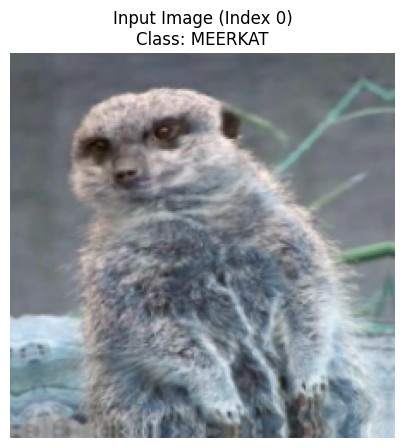


--- Displaying Activations for Image 0 Across resnet50 Layers ---

--- Layer: conv1_relu ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Activations shape for this layer: (112, 112, 64)


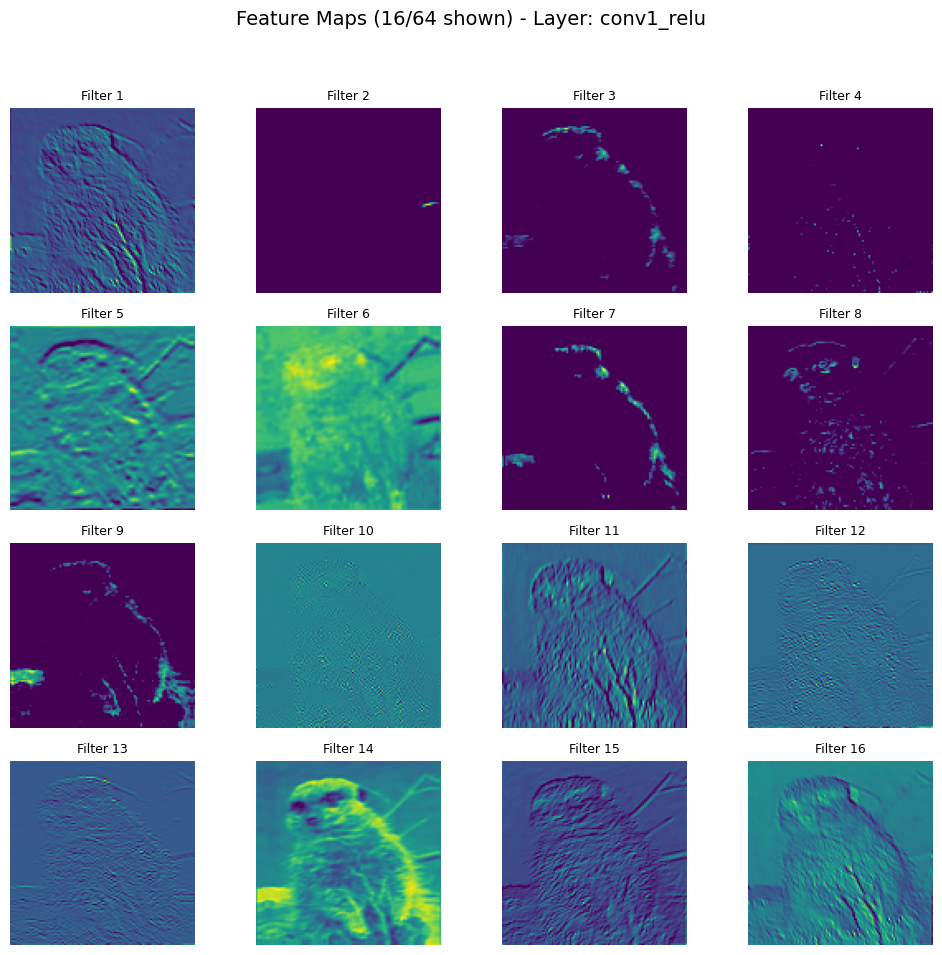

Description for Layer 'conv1_relu':
  - Early layer (Stage 1): Learns basic features (edges, textures). Large receptive field initially.

--- Layer: conv2_block3_out ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Activations shape for this layer: (56, 56, 256)


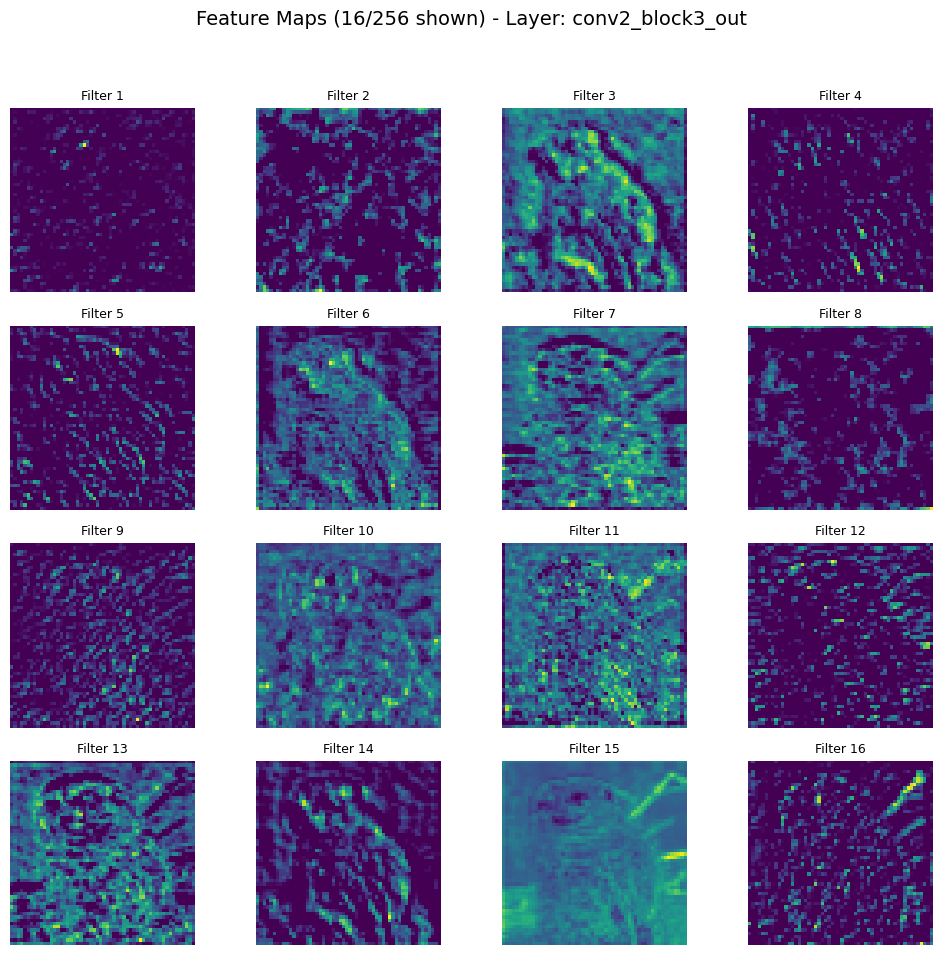

Description for Layer 'conv2_block3_out':
  - Stage 2 Block Output: Combines basic features into slightly more complex patterns. Residual connections start.

--- Layer: conv3_block4_out ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Activations shape for this layer: (28, 28, 512)


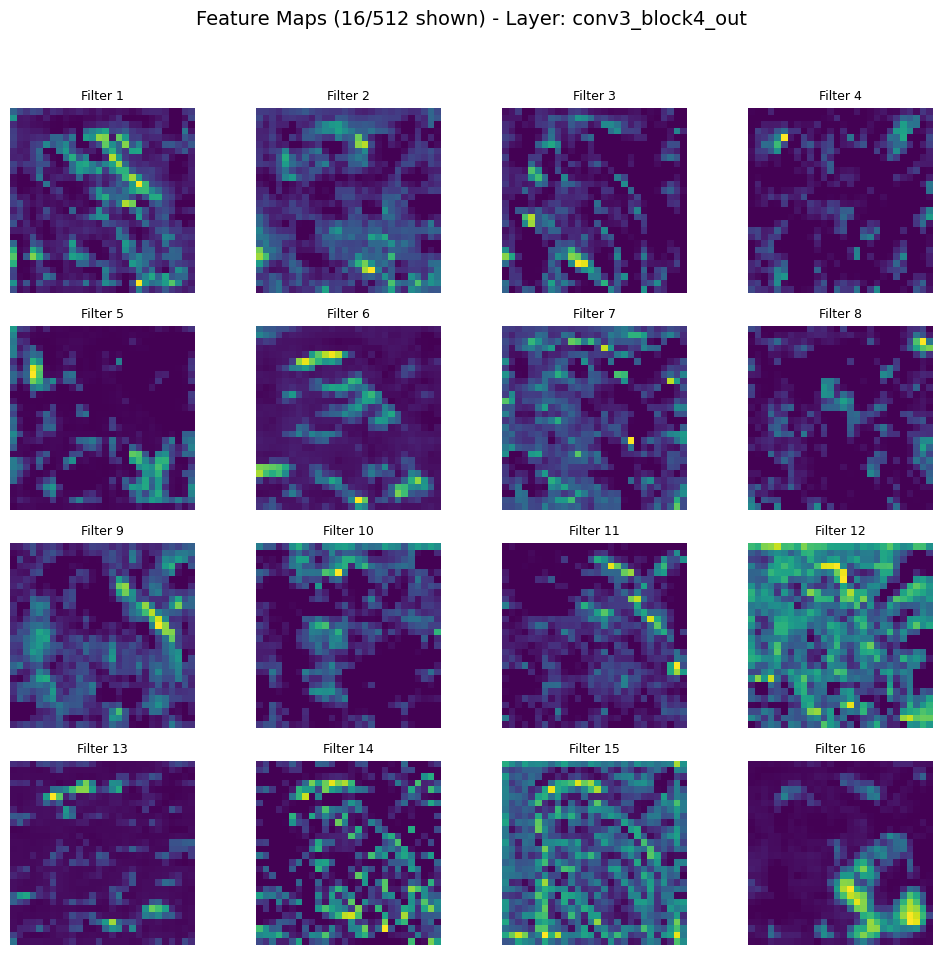

Description for Layer 'conv3_block4_out':
  - Stage 3 Block Output: Learns more intricate patterns and object parts. Feature maps decrease in spatial size, increase in channel depth.

--- Layer: conv4_block6_out ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Activations shape for this layer: (14, 14, 1024)


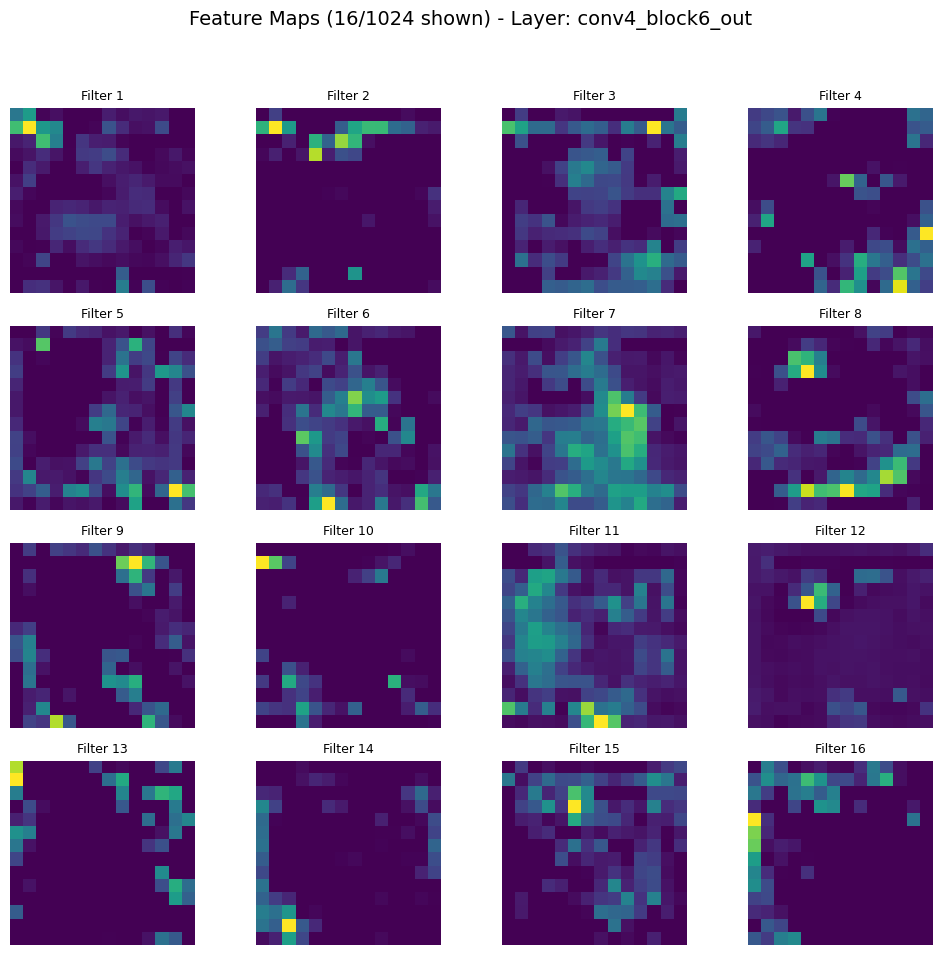

Description for Layer 'conv4_block6_out':
  - Stage 4 Block Output: Detects highly complex, class-relevant features. Significant spatial reduction, high channel depth.


In [22]:
print(f"\n--- Visualizing {MODEL_NAME} Intermediate Layer Outputs ---")

# --- Configuration for Visualization ---
image_index_to_show = 0 # Choose which image from the batch
# --- Update layer names for ResNet50 (Check model_r50.summary()) ---
layer_names_to_visualize_r50 = [
    'conv1_relu',        # Early layer (after first Conv + BN + ReLU)
    'conv2_block3_out',  # Output of a block in stage 2
    'conv3_block4_out',  # Output of a block in stage 3
    'conv4_block6_out'   # Output of a block in stage 4 (deeper)
]
filters_to_show_per_layer = 16

# --- Get Batch and Select Image ---
try:
    # Use the trained ResNet50 model
    current_model_to_visualize = model_r50
    if 'model_r50' not in locals() or model_r50 is None:
         print(f"Loading the best saved {MODEL_NAME} model for visualization...")
         current_model_to_visualize = tf.keras.models.load_model(MODEL_SAVE_PATH_R50)
         print("Model loaded.")

    # Get a batch from the ResNet50 training dataset
    img_batch_r50, label_batch_r50 = next(iter(train_ds_r50))
    single_img_processed_r50 = img_batch_r50[image_index_to_show]
    single_label_one_hot_r50 = label_batch_r50[image_index_to_show]
    single_img_batch_r50 = np.expand_dims(single_img_processed_r50, axis=0)

    # --- Display Input Image (Once) ---
    display_img_r50 = (single_img_processed_r50.numpy() * 127.5) + 127.5 # Approx reverse ResNet preprocess
    # Or more accurately: Need to reverse channel-wise mean subtraction if that's part of preprocess_input
    # For basic visualization, scaling back towards 0-255 might suffice:
    display_img_r50 = (single_img_processed_r50.numpy() - single_img_processed_r50.numpy().min())
    display_img_r50 /= display_img_r50.max()
    display_img_r50 = np.clip(display_img_r50, 0, 1)
    label_index_r50 = np.argmax(single_label_one_hot_r50)
    label_name_r50 = CLASSES[label_index_r50]
    plt.figure(figsize=(5, 5))
    plt.imshow(display_img_r50)
    plt.title(f"Input Image (Index {image_index_to_show})\nClass: {label_name_r50}")
    plt.axis('off')
    plt.show()

    # --- Loop Through Layers for Visualization ---
    print(f"\n--- Displaying Activations for Image {image_index_to_show} Across {MODEL_NAME} Layers ---")
    for layer_name in layer_names_to_visualize_r50:
        print(f"\n--- Layer: {layer_name} ---")
        try:
            intermediate_layer_model_r50 = Model(inputs=current_model_to_visualize.input,
                                                 outputs=current_model_to_visualize.get_layer(layer_name).output)
            activations_r50 = intermediate_layer_model_r50.predict(single_img_batch_r50)
            activation_map_r50 = activations_r50[0]
            print(f"Activations shape for this layer: {activation_map_r50.shape}")
            num_filters_in_activation = activation_map_r50.shape[-1]
            current_filters_to_show = min(filters_to_show_per_layer, num_filters_in_activation)

            # --- Display Feature Maps ---
            grid_cols = 4; grid_rows = current_filters_to_show // grid_cols + (current_filters_to_show % grid_cols > 0)
            plt.figure(figsize=(grid_cols * 2.5, grid_rows * 2.5))
            plt.suptitle(f"Feature Maps ({current_filters_to_show}/{num_filters_in_activation} shown) - Layer: {layer_name}", fontsize=14)
            for filter_index in range(current_filters_to_show):
                plt.subplot(grid_rows, grid_cols, filter_index + 1)
                plt.imshow(activation_map_r50[:, :, filter_index], cmap='viridis')
                plt.title(f"Filter {filter_index+1}", fontsize=9)
                plt.axis('off')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

            # --- Update Description for ResNet50 ---
            print(f"Description for Layer '{layer_name}':")
            if 'conv1' in layer_name:
                 print("  - Early layer (Stage 1): Learns basic features (edges, textures). Large receptive field initially.")
            elif 'conv2' in layer_name:
                 print("  - Stage 2 Block Output: Combines basic features into slightly more complex patterns. Residual connections start.")
            elif 'conv3' in layer_name:
                 print("  - Stage 3 Block Output: Learns more intricate patterns and object parts. Feature maps decrease in spatial size, increase in channel depth.")
            elif 'conv4' in layer_name:
                 print("  - Stage 4 Block Output: Detects highly complex, class-relevant features. Significant spatial reduction, high channel depth.")
            elif 'conv5' in layer_name:
                 print("  - Stage 5 Block Output (Deepest): Very abstract features, highly specialized for classification before Global Average Pooling.")
            else:
                 print("  - Layer within a ResNet block or other component.")

        except Exception as e_inner: print(f"  Error processing layer {layer_name}: {e_inner}. Skipping.")

except Exception as e_outer: print(f"An overall error occurred during visualization setup: {e_outer}")

In [23]:
print(f"\n--- Module 2 ({MODEL_NAME} with tf.data, Single GPU) Summary ---")
print(f"1. Built {MODEL_NAME} model: Loaded base, froze layers, added custom head.")
print(f"2. Created tf.data pipelines using {MODEL_NAME}'s preprocess_input and disk caching.")
print(f"3. Loaded class weights from '{os.path.basename(WEIGHTS_FILE)}'.")
print(f"4. Compiled model (Adam LR={LEARNING_RATE}, categorical_crossentropy, accuracy, top_5_accuracy).")
print(f"5. Trained model using tf.data datasets with EarlyStopping and ModelCheckpoint.")
print(f"   - Best model saved to: {MODEL_SAVE_PATH_R50}")
print(f"   - History saved to: {HISTORY_SAVE_PATH_R50}")
print(f"6. Visualized activations from selected intermediate layers.")
print("\nModule 2 ({MODEL_NAME}) Complete. Ready for Module 3: Evaluation and Fine-tuning.")


--- Module 2 (resnet50 with tf.data, Single GPU) Summary ---
1. Built resnet50 model: Loaded base, froze layers, added custom head.
2. Created tf.data pipelines using resnet50's preprocess_input and disk caching.
3. Loaded class weights from 'class_weights.json'.
4. Compiled model (Adam LR=0.0001, categorical_crossentropy, accuracy, top_5_accuracy).
5. Trained model using tf.data datasets with EarlyStopping and ModelCheckpoint.
   - Best model saved to: /kaggle/working/module_2_outputs/resnet50_tfdata_best.keras
   - History saved to: /kaggle/working/module_2_outputs/resnet50_tfdata_history.pkl
6. Visualized activations from selected intermediate layers.

Module 2 ({MODEL_NAME}) Complete. Ready for Module 3: Evaluation and Fine-tuning.


### ConvNeXt Base

In [24]:
print("TensorFlow Version:", tf.__version__)
print("--- Ensuring Module 1 Variables are Accessible ---")
# Add checks or print statements if needed
print(f"Train Directory: {TRAIN_DIR}")
print(f"Validation Directory: {VAL_DIR}")
print(f"Number of Classes: {NUM_CLASSES}")

# --- Module 2 Configuration (Update for ConvNeXt Base) ---
MODULE_2_OUTPUT_DIR = '/kaggle/working/module_2_outputs' # Keep same output base dir
os.makedirs(MODULE_2_OUTPUT_DIR, exist_ok=True)

# --- ConvNeXt Base Specific File Paths ---
MODEL_NAME = 'convnext_base' # <--- Update Model Name
MODEL_SAVE_PATH_CNB = os.path.join(MODULE_2_OUTPUT_DIR, f'{MODEL_NAME}_tfdata_best.keras')
HISTORY_SAVE_PATH_CNB = os.path.join(MODULE_2_OUTPUT_DIR, f'{MODEL_NAME}_tfdata_history.pkl')
# Use distinct cache filenames
TRAIN_CACHE_FILE_CNB = f'/kaggle/working/tf_train_cache_{MODEL_NAME}'
VAL_CACHE_FILE_CNB = f'/kaggle/working/tf_val_cache_{MODEL_NAME}'

# --- Shared Parameters (Keep from previous setup or adjust) ---
WEIGHTS_FILE = os.path.join(SUM_DIR, 'class_weights.json')
EPOCHS = 30 # Adjust as needed for ConvNeXt
LEARNING_RATE = 0.0001 # Start with same LR, may need tuning
PATIENCE = 5
AUTOTUNE = tf.data.AUTOTUNE
# BATCH_SIZE is defined from previous setup (e.g., 32)
# Note: ConvNeXt Base can be memory intensive. Verify BATCH_SIZE fits single GPU memory.
print(f"Using Batch Size: {BATCH_SIZE}")

print(f"--- Module 2 Setup ({MODEL_NAME}) ---")
print(f"Output directory: {MODULE_2_OUTPUT_DIR}")
print(f"Model save path: {MODEL_SAVE_PATH_CNB}")
print(f"History save path: {HISTORY_SAVE_PATH_CNB}")
print(f"Train cache file: {TRAIN_CACHE_FILE_CNB}")
print(f"Validation cache file: {VAL_CACHE_FILE_CNB}")
print(f"Class weights file: {WEIGHTS_FILE}")

TensorFlow Version: 2.17.1
--- Ensuring Module 1 Variables are Accessible ---
Train Directory: /kaggle/input/zoo-2000/Wild_Animals/Train
Validation Directory: /kaggle/input/zoo-2000/Wild_Animals/Validation
Number of Classes: 21
Using Batch Size: 32
--- Module 2 Setup (convnext_base) ---
Output directory: /kaggle/working/module_2_outputs
Model save path: /kaggle/working/module_2_outputs/convnext_base_tfdata_best.keras
History save path: /kaggle/working/module_2_outputs/convnext_base_tfdata_history.pkl
Train cache file: /kaggle/working/tf_train_cache_convnext_base
Validation cache file: /kaggle/working/tf_val_cache_convnext_base
Class weights file: /kaggle/working/module_1_outputs/data_summaries/class_weights.json


In [ ]:
# print(f"--- Cleaning up ALL cache files AND saved model for {MODEL_NAME} ---")

# # 1. Remove Cache Files
# # ---------------------
# cache_prefixes_cnb = [
#     TRAIN_CACHE_FILE_CNB,
#     VAL_CACHE_FILE_CNB
# ]
# cache_files_removed = 0
# cache_errors = 0

# print("\nAttempting to remove cache files...")
# for prefix in cache_prefixes_cnb:
#     files_to_delete = glob.glob(prefix + "*")
#     if files_to_delete:
#         print(f"  Found {len(files_to_delete)} cache files for prefix '{prefix}'.")
#         for file_path in files_to_delete:
#             try:
#                 os.remove(file_path)
#                 cache_files_removed += 1
#             except OSError as e:
#                 print(f"    Error removing cache file {file_path}: {e}")
#                 cache_errors += 1
#     else:
#         print(f"  No cache files found for prefix '{prefix}'.")
# print(f"Cache file removal: Removed {cache_files_removed}, Errors {cache_errors}")

# # 2. Remove Saved Model File (.keras)
# # -----------------------------------
# model_removed = 0
# model_errors = 0

# print(f"\nAttempting to remove saved model file: {MODEL_SAVE_PATH_CNB}")
# if os.path.exists(MODEL_SAVE_PATH_CNB):
#     try:
#         os.remove(MODEL_SAVE_PATH_CNB)
#         print(f"  Successfully removed model file.")
#         model_removed = 1
#     except OSError as e:
#         print(f"  Error removing model file {MODEL_SAVE_PATH_CNB}: {e}")
#         model_errors = 1
# else:
#     print(f"  Model file not found (already removed or never created).")

# # 3. Remove Saved History File (.pkl) - Optional but recommended for full cleanup
# # -----------------------------------
# # HISTORY_SAVE_PATH_CNB = os.path.join(MODULE_2_OUTPUT_DIR, f'{MODEL_NAME}_tfdata_history.pkl') # Ensure defined
# history_removed = 0
# history_errors = 0
# print(f"\nAttempting to remove saved history file: {HISTORY_SAVE_PATH_CNB}")
# if os.path.exists(HISTORY_SAVE_PATH_CNB):
#     try:
#         os.remove(HISTORY_SAVE_PATH_CNB)
#         print(f"  Successfully removed history file.")
#         history_removed = 1
#     except OSError as e:
#         print(f"  Error removing history file {HISTORY_SAVE_PATH_CNB}: {e}")
#         history_errors = 1
# else:
#     print(f"  History file not found.")


# print(f"\n--- Full {MODEL_NAME} cleanup finished. ---")
# print(f"  Cache Files: Removed={cache_files_removed}, Errors={cache_errors}")
# print(f"  Model File: Removed={model_removed}, Errors={model_errors}")
# print(f"  History File: Removed={history_removed}, Errors={history_errors}")

# # Restarting the kernel after this cleanup is still a good idea.

In [25]:
print(f"\n--- Creating tf.data Pipelines for {MODEL_NAME} ---")

# --- Helper Functions ---
# --- Modify this function for ConvNeXt ---
def preprocess_convnext(image, label):
    # Applies ConvNeXt specific preprocessing
    image = tf.cast(image, tf.float32) # Ensure float type
    image = convnext_preprocess_input(image) # Use ConvNeXt's function
    return image, label

# Augmentation function remains the same conceptually
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.05), # Keep consistent initially
  RandomZoom(0.05),
], name="data_augmentation")

def augment_data(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image, training=True)
    return image, label


--- Creating tf.data Pipelines for convnext_base ---


In [26]:
# --- Create Training Dataset ---
print("Creating Training Dataset...")
train_ds_cnb = tf.keras.utils.image_dataset_from_directory( # Renamed variable
    TRAIN_DIR, labels='inferred', label_mode='categorical', class_names=CLASSES,
    image_size=TARGET_SIZE, interpolation='nearest', batch_size=None, shuffle=True, seed=123
)
# Verify class names
if train_ds_cnb.class_names != CLASSES: raise ValueError("Class order mismatch!")
else: print("Class name order verified.")

# Apply disk caching
print(f"Applying Disk Caching (File: {TRAIN_CACHE_FILE_CNB})...")
train_ds_cnb = train_ds_cnb.cache(filename=TRAIN_CACHE_FILE_CNB) # Use CNB cache file
# Apply augmentations
print("Mapping Augmentations...")
train_ds_cnb = train_ds_cnb.map(augment_data, num_parallel_calls=AUTOTUNE)
# Apply ConvNeXt preprocessing
print("Mapping ConvNeXt Preprocessing...")
train_ds_cnb = train_ds_cnb.map(preprocess_convnext, num_parallel_calls=AUTOTUNE) # Use ConvNeXt func
# Batch and Prefetch
print("Batching and Prefetching Training Data...")
train_ds_cnb = train_ds_cnb.batch(BATCH_SIZE)
train_ds_cnb = train_ds_cnb.prefetch(buffer_size=AUTOTUNE)
print("Training Dataset Pipeline Ready.")

Creating Training Dataset...
Found 24430 files belonging to 21 classes.
Class name order verified.
Applying Disk Caching (File: /kaggle/working/tf_train_cache_convnext_base)...
Mapping Augmentations...
Mapping ConvNeXt Preprocessing...
Batching and Prefetching Training Data...
Training Dataset Pipeline Ready.


In [27]:
# --- Create Validation Dataset ---
print("Creating Validation Dataset...")
val_ds_cnb = tf.keras.utils.image_dataset_from_directory( # Renamed variable
    VAL_DIR, labels='inferred', label_mode='categorical', class_names=CLASSES,
    image_size=TARGET_SIZE, interpolation='nearest', batch_size=None, shuffle=False
)
# Apply disk caching
print(f"Applying Disk Caching (File: {VAL_CACHE_FILE_CNB})...")
val_ds_cnb = val_ds_cnb.cache(filename=VAL_CACHE_FILE_CNB) # Use CNB cache file
# Apply ConvNeXt preprocessing (NO augmentation)
print("Mapping ConvNeXt Preprocessing...")
val_ds_cnb = val_ds_cnb.map(preprocess_convnext, num_parallel_calls=AUTOTUNE) # Use ConvNeXt func
# Batch and Prefetch
print("Batching and Prefetching Validation Data...")
val_ds_cnb = val_ds_cnb.batch(BATCH_SIZE)
val_ds_cnb = val_ds_cnb.prefetch(buffer_size=AUTOTUNE)
print("Validation Dataset Pipeline Ready.")

Creating Validation Dataset...
Found 4170 files belonging to 21 classes.
Applying Disk Caching (File: /kaggle/working/tf_val_cache_convnext_base)...
Mapping ConvNeXt Preprocessing...
Batching and Prefetching Validation Data...
Validation Dataset Pipeline Ready.


In [28]:
print(f"\n--- Building and Compiling {MODEL_NAME} Model (Single Device) ---")

# Load Pre-trained ConvNeXt Base
base_model_cnb = ConvNeXtBase(
    # model_name='convnext_base', # Explicitly state model name
    include_top=False,          # Exclude classifier
    include_preprocessing=False,# Typically False, preprocessing is done in tf.data
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
print(f"{MODEL_NAME} base model loaded.")

# Freeze Base Layers
base_model_cnb.trainable = False
print("Base model layers frozen.")

# Add Custom Head (Same structure as before)
x_cnb = base_model_cnb.output
x_cnb = GlobalAveragePooling2D()(x_cnb)
# ConvNeXt outputs are often high-dimensional, maybe add LayerNorm before Dense
# x_cnb = LayerNormalization(epsilon=1e-6)(x_cnb) # Optional, experiment if needed
x_cnb = Dense(256, activation='relu')(x_cnb) # Keep intermediate Dense for now
x_cnb = Dropout(0.5)(x_cnb)
predictions_cnb = Dense(NUM_CLASSES, activation='softmax')(x_cnb)
model_cnb = Model(inputs=base_model_cnb.input, outputs=predictions_cnb)
print("Custom head added.")

# Compile Model
optimizer_cnb = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE) # Use same LR initially
model_cnb.compile(
    optimizer=optimizer_cnb,
    loss='categorical_crossentropy',
    metrics=['accuracy', TopKCategoricalAccuracy(k=5, name='top_5_accuracy')]
)
print(f"{MODEL_NAME} model compiled successfully.")

# Model Summary
print(f"\n--- Final {MODEL_NAME} Model Summary (Single Device) ---")
model_cnb.summary() # Check layer names here for visualization later


--- Building and Compiling convnext_base Model (Single Device) ---
350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
convnext_base base model loaded.
Base model layers frozen.
Custom head added.
convnext_base model compiled successfully.

--- Final convnext_base Model Summary (Single Device) ---


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stem        │ (None, 56, 56, 128)    │          6,528 │ input_layer_3[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │          6,400 │ convnext_base_stem[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │            256 │ convnext_base_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 512)    │         66,048 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 512)    │              0 │ convnext_base_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │         65,664 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │            128 │ convnext_base_stage_0… │
│ (LayerScale)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │              0 │ convnext_base_stage_0… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 56, 56, 128)    │              0 │ convnext_base_stem[0]… │
│                           │                        │                │ convnext_base_stage_0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │          6,400 │ add[0][0]              │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 128)    │            256 │ convnext_base_stage_0… │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ convnext_base_stage_0_bl… │ (None, 56, 56, 512)    │         66,048 │ convnext_base_stage_0… │
│ (Dense)                   │                        │                │                        │
├──────────────────────

 Total params: 87,834,261 (335.06 MB)

 Trainable params: 267,797 (1.02 MB)

 Non-trainable params: 87,566,464 (334.04 MB)

In [29]:
print("\n--- Loading Class Weights from File ---")
class_weights = None # Keep variable name consistent
try:
    # ... (Same loading code as before using WEIGHTS_FILE) ...
    print(f"Successfully loaded class weights from {WEIGHTS_FILE}")
    # ... (Optional consistency check) ...
except Exception as e:
    print(f"ERROR loading class weights: {e}. Proceeding without weights.")


--- Loading Class Weights from File ---
Successfully loaded class weights from /kaggle/working/module_1_outputs/data_summaries/class_weights.json


In [30]:
print("\n--- Defining Callbacks ---")
early_stopping_cnb = EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True, verbose=1, mode='max')
# --- Update filepath for ConvNeXt ---
model_checkpoint_cnb = ModelCheckpoint(filepath=MODEL_SAVE_PATH_CNB, # Use ConvNeXt path
                                       monitor='val_accuracy', save_best_only=True,
                                       save_weights_only=False, mode='max', verbose=1)
callbacks_list_cnb = [early_stopping_cnb, model_checkpoint_cnb]
print(f"Callbacks defined (EarlyStopping, ModelCheckpoint for {MODEL_NAME}).")


--- Defining Callbacks ---
Callbacks defined (EarlyStopping, ModelCheckpoint for convnext_base).


In [ ]:
print(f"\n--- Starting {MODEL_NAME} Model Training (Single Device) ---")
history_cnb = model_cnb.fit(
    train_ds_cnb,               # Use ConvNeXt training data
    epochs=EPOCHS,
    validation_data=val_ds_cnb, # Use ConvNeXt validation data
    callbacks=callbacks_list_cnb, # Use ConvNeXt callbacks
    class_weight=class_weights, # Use loaded class weights
    verbose=1
)
print(f"--- {MODEL_NAME} Model Training Finished ---")

# Save history
try:
    with open(HISTORY_SAVE_PATH_CNB, 'wb') as f: # Use ConvNeXt history path
        pickle.dump(history_cnb.history, f)
    print(f"Training history saved successfully to {HISTORY_SAVE_PATH_CNB}")
except Exception as e:
    print(f"Error saving training history: {e}")


--- Visualizing convnext_base Intermediate Layer Outputs ---


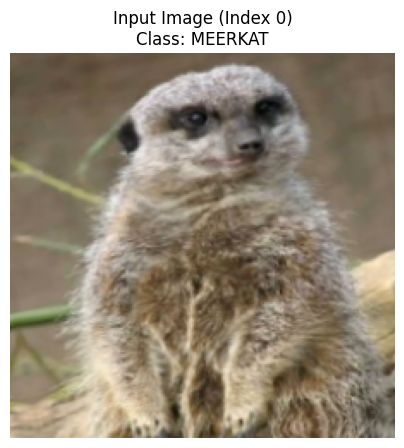


--- Displaying Activations for Image 0 Across convnext_base Layers ---

--- Layer: convnext_base_stem ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Activations shape for this layer: (56, 56, 128)


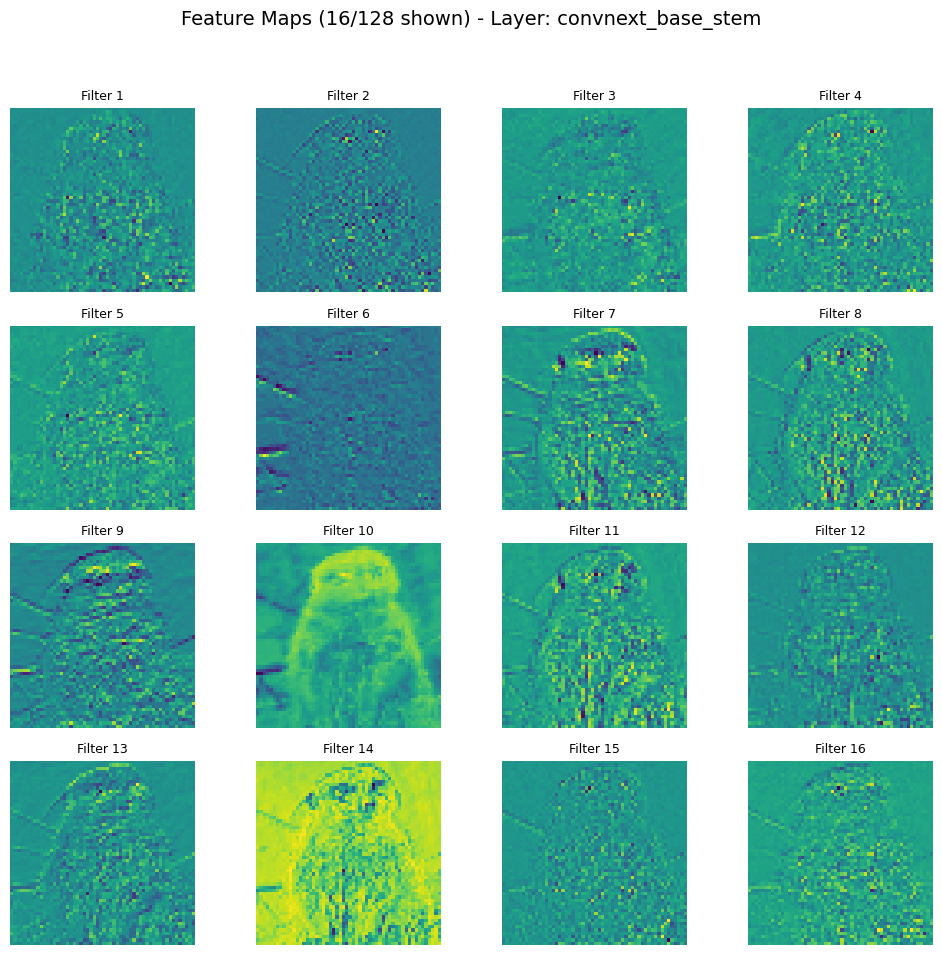

Description for Layer 'convnext_base_stem':
  - Early layer (Stem): Initial downsampling and feature extraction via Conv + LayerNorm.

--- Layer: convnext_base_stage_0_block_1_layer_scale ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step
Activations shape for this layer: (56, 56, 128)


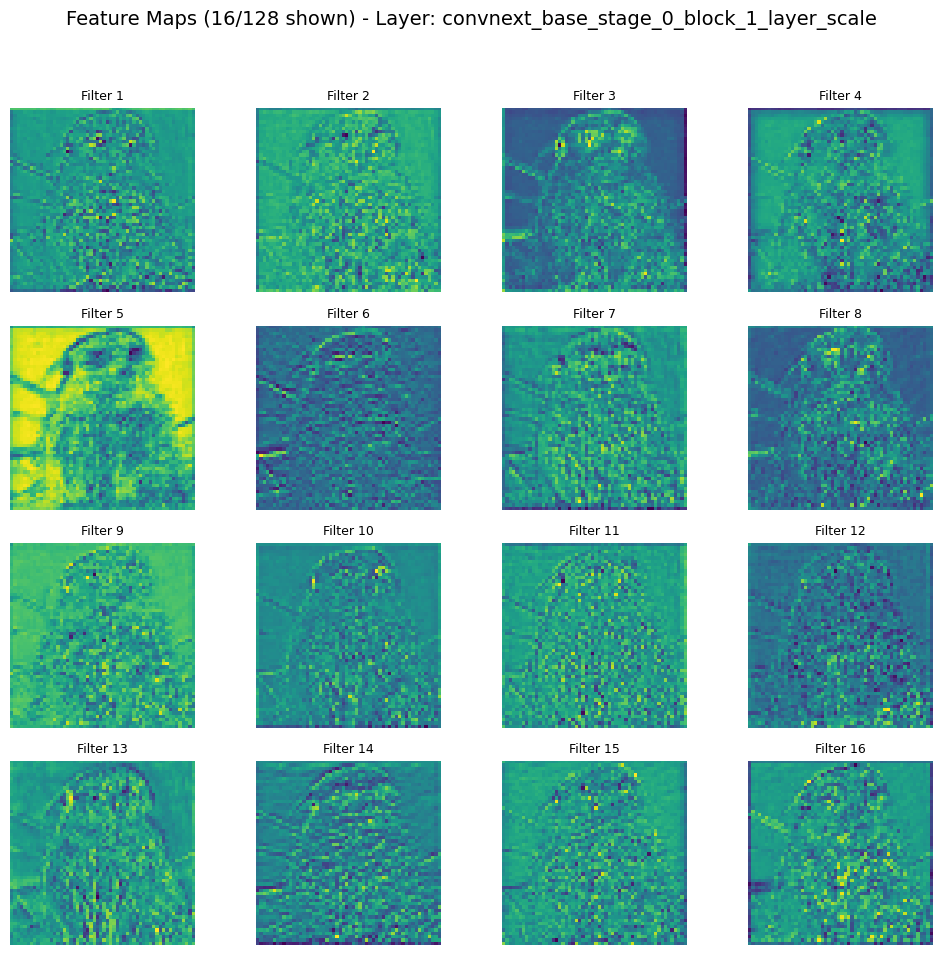

Description for Layer 'convnext_base_stage_0_block_1_layer_scale':
  - Stage 0 Block: Processes features at higher resolution. Uses Depthwise Conv, LayerNorm, MLP blocks.

--- Layer: convnext_base_stage_1_block_1_gelu ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Activations shape for this layer: (28, 28, 1024)


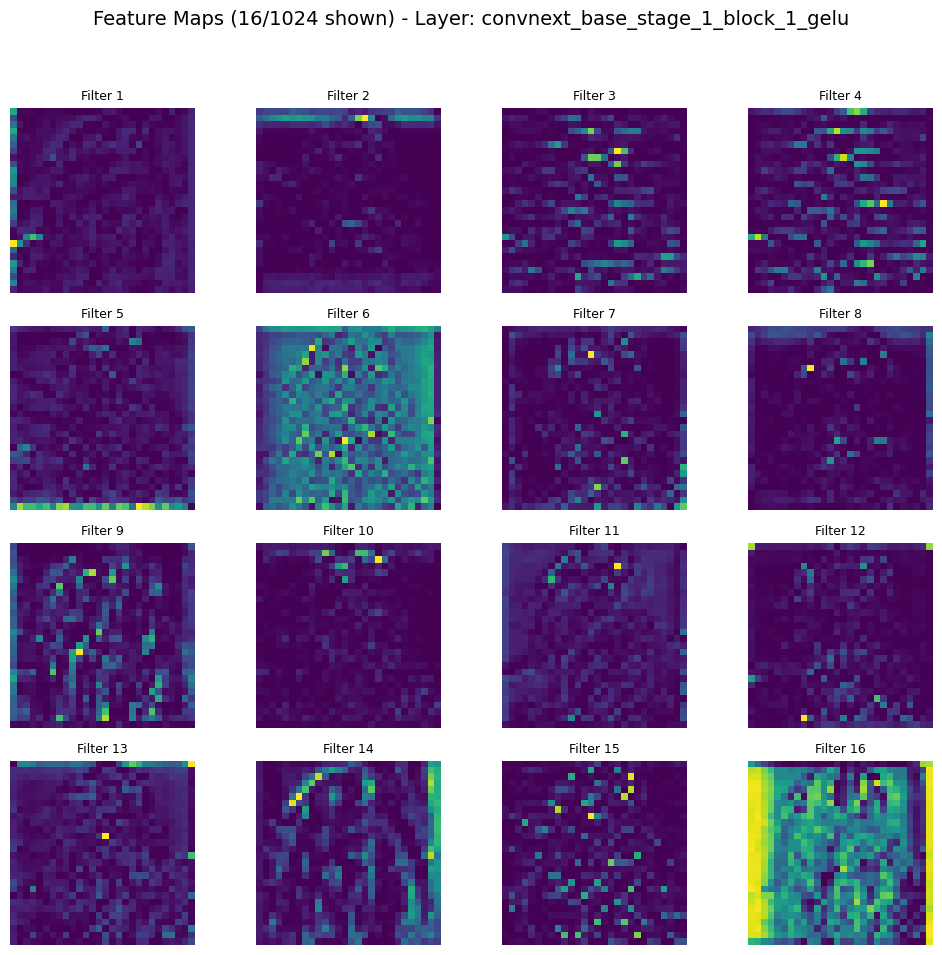

Description for Layer 'convnext_base_stage_1_block_1_gelu':
  - Stage 1 Block: Further feature transformation, increased channel depth likely. Spatial resolution may decrease.

--- Layer: convnext_base_stage_2_block_2_identity ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Activations shape for this layer: (14, 14, 512)


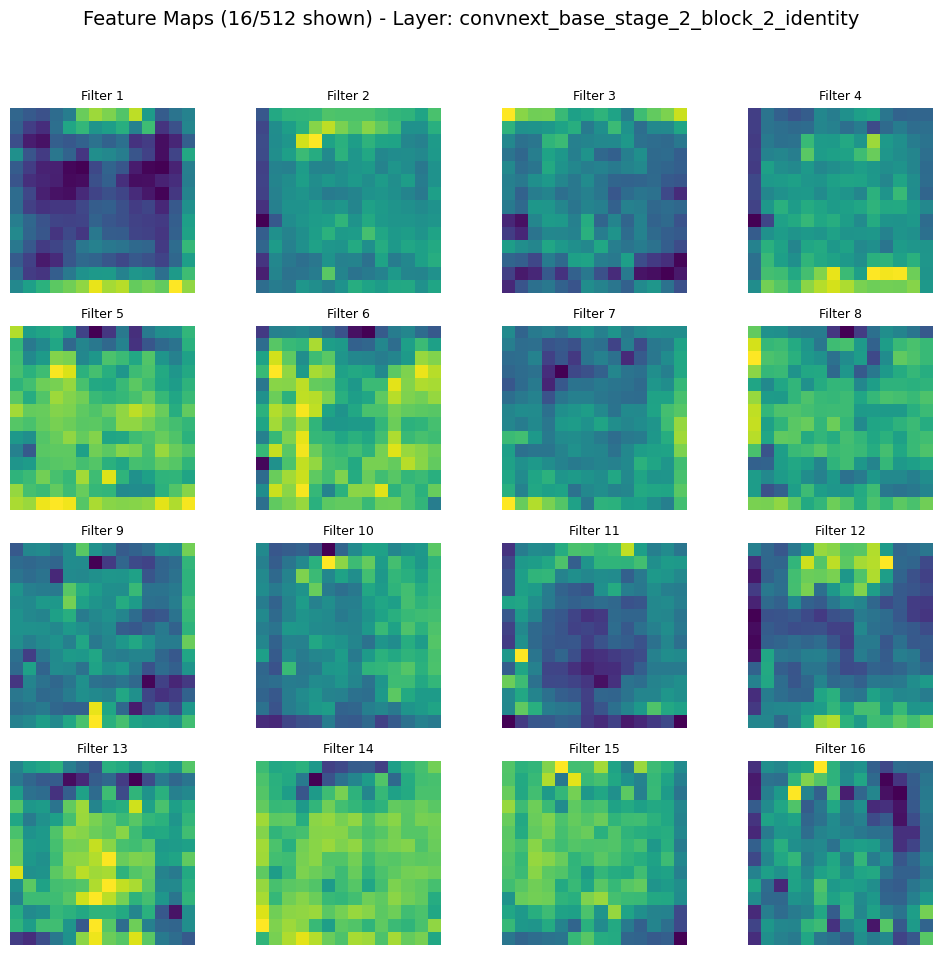

Description for Layer 'convnext_base_stage_2_block_2_identity':
  - Stage 2 Block: Deeper feature extraction, more abstract representations. Significant channel depth.

--- convnext_base Layer Visualization Finished ---


In [31]:
# --- Visualization Code Block for ConvNeXt Base ---

# --- Ensure these variables are defined from ConvNeXt Setup ---
# MODEL_NAME = 'convnext_base'
# MODEL_SAVE_PATH_CNB: Path to the saved ConvNeXt .keras file
# train_ds_cnb: The tf.data training dataset for ConvNeXt
# model_cnb: The trained ConvNeXt model object (if still in memory)
# CLASSES: List of class names
# plt, np, os, tf, Model should be imported

print(f"\n--- Visualizing {MODEL_NAME} Intermediate Layer Outputs ---")

# --- Configuration for Visualization ---
image_index_to_show = 0 # Choose which image from the batch
# --- !!! UPDATE layer names for ConvNeXt (Check model_cnb.summary()) !!! ---
# Example names (VERIFY THESE from your actual summary output):
layer_names_to_visualize_cnb = [
    'convnext_base_stem', # After initial stem (Conv + LayerNorm)
    'convnext_base_stage_0_block_1_layer_scale', # Example within first stage blocks
    'convnext_base_stage_1_block_1_gelu', # Example within second stage blocks
    'convnext_base_stage_2_block_2_identity', # Example within third stage blocks
    # 'convnext_base_stage_3_block_1_layer_norm' # Example within final stage
]
filters_to_show_per_layer = 16

# --- Get Batch and Select Image ---
try:
    # Use the trained ConvNeXt model (load if not in memory)
    current_model_to_visualize = model_cnb # Assumes model_cnb exists
    if 'model_cnb' not in locals() or model_cnb is None:
         print(f"Loading the best saved {MODEL_NAME} model for visualization...")
         # Ensure MODEL_SAVE_PATH_CNB is correctly defined
         current_model_to_visualize = tf.keras.models.load_model(MODEL_SAVE_PATH_CNB)
         print("Model loaded.")

    # Get a batch from the ConvNeXt training dataset
    # Ensure train_ds_cnb is accessible
    img_batch_cnb, label_batch_cnb = next(iter(train_ds_cnb))
    single_img_processed_cnb = img_batch_cnb[image_index_to_show]
    single_label_one_hot_cnb = label_batch_cnb[image_index_to_show]
    # Add batch dimension back for prediction
    single_img_batch_cnb = np.expand_dims(single_img_processed_cnb, axis=0)

    # --- Display Input Image (Once) ---
    # Approximate reversal of ConvNeXt preprocessing (often uses ImageNet mean/std)
    # Simple rescale to [0, 1] for basic visualization:
    display_img_cnb = (single_img_processed_cnb.numpy() - single_img_processed_cnb.numpy().min())
    display_img_cnb /= display_img_cnb.max() + 1e-6 # Add epsilon for safety
    display_img_cnb = np.clip(display_img_cnb, 0, 1)
    label_index_cnb = np.argmax(single_label_one_hot_cnb)
    label_name_cnb = CLASSES[label_index_cnb]
    plt.figure(figsize=(5, 5)); plt.imshow(display_img_cnb)
    plt.title(f"Input Image (Index {image_index_to_show})\nClass: {label_name_cnb}"); plt.axis('off'); plt.show()

    # --- Loop Through Layers for Visualization ---
    print(f"\n--- Displaying Activations for Image {image_index_to_show} Across {MODEL_NAME} Layers ---")
    # Use the specific list for ConvNeXt layers
    for layer_name in layer_names_to_visualize_cnb:
        print(f"\n--- Layer: {layer_name} ---")
        try:
            # Create intermediate model using the loaded/current ConvNeXt model
            intermediate_layer_model_cnb = Model(inputs=current_model_to_visualize.input,
                                                 outputs=current_model_to_visualize.get_layer(layer_name).output)
            # Predict using the preprocessed single image batch
            activations_cnb = intermediate_layer_model_cnb.predict(single_img_batch_cnb)
            # Remove batch dimension for plotting
            activation_map_cnb = activations_cnb[0]
            print(f"Activations shape for this layer: {activation_map_cnb.shape}")
            num_filters_in_activation = activation_map_cnb.shape[-1]
            current_filters_to_show = min(filters_to_show_per_layer, num_filters_in_activation)

            # --- Display Feature Maps ---
            if current_filters_to_show <= 0:
                print("  No filters to show for this layer.")
                continue

            grid_cols = 4; grid_rows = current_filters_to_show // grid_cols + (current_filters_to_show % grid_cols > 0)
            plt.figure(figsize=(grid_cols * 2.5, grid_rows * 2.5))
            plt.suptitle(f"Feature Maps ({current_filters_to_show}/{num_filters_in_activation} shown) - Layer: {layer_name}", fontsize=14)
            for filter_index in range(current_filters_to_show):
                plt.subplot(grid_rows, grid_cols, filter_index + 1)
                if activation_map_cnb.shape[-1] == 1:
                    plt.imshow(activation_map_cnb[:, :, 0], cmap='viridis')
                else:
                    plt.imshow(activation_map_cnb[:, :, filter_index], cmap='viridis')
                plt.title(f"Filter {filter_index+1}", fontsize=9); plt.axis('off')
            plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

            # --- Update Description for ConvNeXt ---
            print(f"Description for Layer '{layer_name}':")
            if 'stem' in layer_name:
                 print("  - Early layer (Stem): Initial downsampling and feature extraction via Conv + LayerNorm.")
            elif 'stage_0' in layer_name:
                 print("  - Stage 0 Block: Processes features at higher resolution. Uses Depthwise Conv, LayerNorm, MLP blocks.")
            elif 'stage_1' in layer_name:
                 print("  - Stage 1 Block: Further feature transformation, increased channel depth likely. Spatial resolution may decrease.")
            elif 'stage_2' in layer_name:
                 print("  - Stage 2 Block: Deeper feature extraction, more abstract representations. Significant channel depth.")
            elif 'stage_3' in layer_name:
                 print("  - Stage 3 Block (Deepest Stage): Highly complex features relevant for classification before final LayerNorm/GAP.")
            else:
                 print("  - Layer within a ConvNeXt block or other component.")

        # Error handling for specific layer processing
        except ValueError as e:
             print(f"    ERROR: Could not find layer '{layer_name}'. Check model summary. Skipping.")
        except Exception as e_inner:
             print(f"    Error processing layer {layer_name}: {e_inner}. Skipping.")

# Outer error handling for overall setup issues
except NameError as e:
    print(f"ERROR: A required variable (like model_cnb, train_ds_cnb etc.) might not be defined.")
    print(e)
except Exception as e_outer:
    print(f"An overall error occurred during visualization setup: {e_outer}")

print(f"\n--- {MODEL_NAME} Layer Visualization Finished ---")

In [ ]:
# # Add this BEFORE the visualization loop to see the correct layer names

# print("\n--- Printing ConvNeXt Model Summary to Verify Layer Names ---")
# try:
#     # Ensure the model object exists (either model_cnb or current_model_to_visualize)
#     model_to_summarize = None
#     if 'current_model_to_visualize' in locals() and current_model_to_visualize is not None:
#         model_to_summarize = current_model_to_visualize
#     elif 'model_cnb' in locals() and model_cnb is not None:
#         model_to_summarize = model_cnb
#     else:
#          print("Model object not found for summary.")

#     if model_to_summarize:
#          model_to_summarize.summary(line_length=150) # Use longer line length to see full names

# except Exception as e:
#     print(f"Could not print model summary: {e}")
# print("--- End Model Summary ---")

# # Now proceed with the rest of the visualization code...
# # try:
# #    ... (Get Batch and Select Image) ...
# #    ... (Display Input Image) ...
# #    ... (Loop Through Layers for Visualization) ...

In [32]:
print(f"\n--- Module 2 ({MODEL_NAME} with tf.data, Single GPU) Summary ---")
print(f"1. Built {MODEL_NAME} model: Loaded base, froze layers, added custom head.")
print(f"2. Created tf.data pipelines using {MODEL_NAME}'s preprocess_input and disk caching.")
print(f"3. Loaded class weights from '{os.path.basename(WEIGHTS_FILE)}'.")
print(f"4. Compiled model (Adam LR={LEARNING_RATE}, categorical_crossentropy, accuracy, top_5_accuracy).")
print(f"5. Trained model using tf.data datasets with EarlyStopping and ModelCheckpoint.")
print(f"   - Best model saved to: {MODEL_SAVE_PATH_CNB}")
print(f"   - History saved to: {HISTORY_SAVE_PATH_CNB}")
print(f"6. Visualized activations from selected intermediate layers.")
print("\nModule 2 ({MODEL_NAME}) Complete. Ready for Module 3: Evaluation and Fine-tuning.")


--- Module 2 (convnext_base with tf.data, Single GPU) Summary ---
1. Built convnext_base model: Loaded base, froze layers, added custom head.
2. Created tf.data pipelines using convnext_base's preprocess_input and disk caching.
3. Loaded class weights from 'class_weights.json'.
4. Compiled model (Adam LR=0.0001, categorical_crossentropy, accuracy, top_5_accuracy).
5. Trained model using tf.data datasets with EarlyStopping and ModelCheckpoint.
   - Best model saved to: /kaggle/working/module_2_outputs/convnext_base_tfdata_best.keras
   - History saved to: /kaggle/working/module_2_outputs/convnext_base_tfdata_history.pkl
6. Visualized activations from selected intermediate layers.

Module 2 ({MODEL_NAME}) Complete. Ready for Module 3: Evaluation and Fine-tuning.
